<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones básicas en numpy
* Preprocesamiento y exploración de datos, creación de datos sinteticos
* Regresión Lineal Regularizada: _Ridge_ y _Lasso_
* SVM y Kernels
* Más _Cross Validation_


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ (en caso de ser repositorio privado, invitar como colaborador al usuario de github "avalderr") al correo electrónico del ayudante (*<alvaro.valderrama.13@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF393/578-2019 Tarea2]
* Fecha de entrega y presentaciones: 31 de Mayo. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en dos partes:

[1.](#primero) Clasificación de datos no-linealmente separables  
[2.](#tercero) Regularización para regresión   

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.
Si algun modelo se demora demasiado en correr en su maquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, esto puede ser relevante para las maquinas más lentas al momento de realizar exploraciones con _K-folds_ por ejemplo.

<a id="primero"></a>
## 1. Clasificación de datos no-linealmente separables

Algunos modelos de clasificación buscan implicita o explicitamente separar los datos linealmente, es decir ajustar un hiperplano que separe en 2 subespacios el espacio de las variables, separando ambas clases del _target_. Sin embargo en la mayoría de los casos reales esto resulta imposible. Esto no significa que no podamos ajustar modelos con estos datos o buscar transformaciones que nos permitan utilizarlos. 
    
![Alt Text](http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.gif) 

[comment]: <> (Swiss Roll)

En esta primera parte de la tarea crearemos manualmente un set de datos categóricos no linealmente separables. Este se conformará de puntos en $\mathbb{R}^2$, pertenecientes a una de dos categorías etiquetadas 0 o 1, los cuales se encuentran "anidados". Probaremos distintas aproximaciones lineales y no lineales y compararemos sus desempeños.


#### 1.a Creando los datos
La función `do_circles` retorna un conjunto de puntos etiquetados, donde la etiqueta 0 corresponde a puntos siguiendo una circunferencia (con un ruido asociado) y la etiqueta 1 a puntos dentro de esa circunferencia.

In [1]:
def do_circles(n_dots = 1000, ns = 0.05, scr = 0.3, cf = 1):
    generator = check_random_state(42)
    
    linspace = np.linspace(0, 2*cf*np.pi, n_dots)
    circle_x = np.cos(linspace)
    circle_y = np.sin(linspace)

    inner_circle_x, outer_circle_x, inner_circle_y, outer_circle_y = train_test_split(circle_x, circle_y, test_size = 0.5)
    inner_circle_x , inner_circle_y = inner_circle_x*scr , inner_circle_y*scr 

    X = np.vstack((
        np.append(outer_circle_x, inner_circle_x),
        np.append(outer_circle_y, inner_circle_y)
    )).T

    y = np.hstack([
        np.zeros(n_dots // 2, dtype=np.intp),
        np.ones(n_dots // 2, dtype=np.intp)
    ])

    X += generator.normal(scale = ns, size = X.shape)
    return train_test_split(X, y, test_size=0.3, random_state=42)

*Comentario: La función do_circles entrega 2 circunferencias de distinto radio con ruido normal, éstas se denominarán circunferencia exterior e interior según su radio y poseeran etiquetas que las diferenciarán, posee 4 parámetros que alterarán su resultado; 
<br><br> __n_dots__: Indica la cantidad de puntos que componen tanto la circunferencia como los puntos en su interior (Los puntos en su interior también forman una circunferencia de menor radio)
<br><br> __ns__: Indica la cantidad de ruido normal que se le añade a ambas circunferencias (Exterior e interior)
<br><br> __scr__: Indica qué proporción de radio seguirá la circunferencia interior respecto a la exterior. Este valor debe ser menor que 1, caso contrario se debiesen invertir las etiquetas.
<br><br> __cf__: Permite modificar el perímetro de las circunferencias, siendo el perímetro de éstas cf$\cdot$2$\cdot$pi$\cdot$r según el radio de cada circunferencia. Para valores mayores de 1 será posible que exista cierta concentración de puntos, por ejemplo para cf=1.25 existirá concentración de puntos en el primer cuadrante, puesto la totalidad de puntos debiese repartirse en las proporciones ($\frac{2}{5}$,$\frac{1}{5}$,$\frac{1}{5}$,$\frac{1}{5}$) para el 1er, 2do, 3er y 4to cuadrante respectivamente. Para valores menores que 1 no se alcanzarían a trazar circunferencias completas, tanto interior como exterior. Se recomienda usar tan solo valores enteros.*

#### 1.b Graficar los datos
Se crea una función que grafíque los datos, coloreando distintamente los puntos de cada clase. 

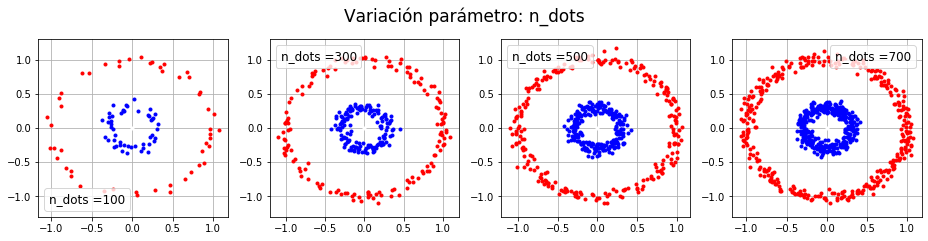

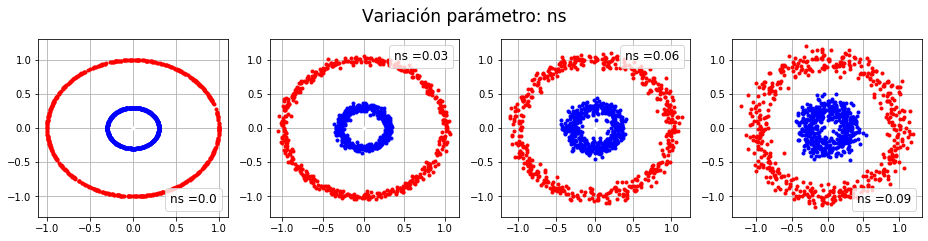

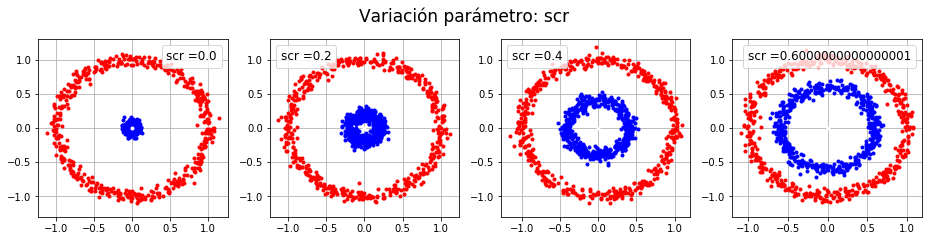

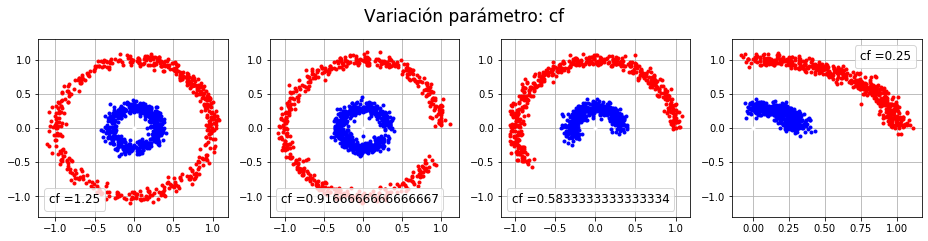

In [13]:
from sklearn.utils import check_random_state
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
def plotea(x_tr,x_tst,y_tr,y_tst,a,b,c,d,e):
    plt.suptitle('Variación parámetro: '+e,y=1.1,size=17)
    plt.subplot(a,b,c)
    for dot in range(y_tr.shape[0]):
        if y_tr[dot]==0:
            plt.plot(x_tr[dot,0],x_tr[dot,1],'r.')
        if y_tr[dot]==1:
            plt.plot(x_tr[dot,0],x_tr[dot,1],'b.')
    for dot in range(y_tst.shape[0]):
        if y_tst[dot]==0:
            plt.plot(x_tst[dot,0],x_tst[dot,1],'r.')
        if y_tst[dot]==1:
            plt.plot(x_tst[dot,0],x_tst[dot,1],'b.')
    plt.plot(0,0,'w.',label=d)
    plt.grid()
    plt.legend(handletextpad=-2.0,prop={'size': 12})
    plt.ylim([-1.3,1.3])
    plt.tight_layout()
plt.rcParams["figure.figsize"]=[13,3]
for i in range(4):
    x_tr,x_tst,y_tr,y_tst=do_circles(n_dots=100+200*i)
    plotea(x_tr,x_tst,y_tr,y_tst,1,4,i+1,'n_dots ='+str(int(100+200*i)),'n_dots')
plt.show()
for i in range(4):
    x_tr,x_tst,y_tr,y_tst=do_circles(ns=0.03*i)
    plotea(x_tr,x_tst,y_tr,y_tst,1,4,i+1,'ns ='+str(float(0.03*i)),'ns')
plt.show()
for i in range(4):
    x_tr,x_tst,y_tr,y_tst=do_circles(scr=0.2*i)
    plotea(x_tr,x_tst,y_tr,y_tst,1,4,i+1,'scr ='+str(0.2*i),'scr')
plt.show()
for i in range(4):
    x_tr,x_tst,y_tr,y_tst=do_circles(cf=5/4-1/3*i)
    plotea(x_tr,x_tst,y_tr,y_tst,1,4,i+1,'cf ='+str(float(5/4-1/3*i)),'cf')
plt.show()

*Comentario: Se verifica el comportamiento de la función do_circles de acuerdo a lo mencionado en el punto anterior*

#### 1.c Regresión Logística

Se realiza una regresión logistica para 5000 puntos generados con los siguientes parámetros:
* `do_circles(n_dots=5000, 0.2, 0.3, 1)`
* `do_circles(n_dots=5000, 0, 0.3, 1)`

Se grafican los datos que se desean ajustar

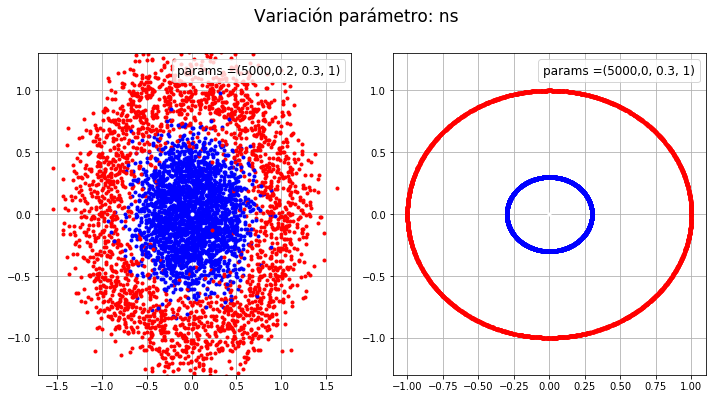

In [3]:
plt.rcParams["figure.figsize"]=[10,5]
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0.2, 0.3, 1)
plotea(x_tr,x_tst,y_tr,y_tst,1,2,1,'params ='+'(5000,0.2, 0.3, 1)','n_dots')
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0, 0.3, 1)
plotea(x_tr,x_tst,y_tr,y_tst,1,2,2,'params ='+'(5000,0, 0.3, 1)','ns')
plt.show()

Se realiza el ajuste por regresión logística y se calcula el _score_ en cada caso.

*Comentario: Dada la rapidez del ajuste y la aleatoriedad del ruido bajo distribución normal se opta por realizar 1000 ajustes y calcular el score como el promedio de todos los scores obtenidos para ambas elecciones de parámetros para la generación de círculos*

In [4]:
from sklearn.linear_model import LogisticRegression
ps,ss,c=list(),list(),0
for j in range(1000):
    x_tr,x_tst,y_tr,y_tst=do_circles(5000,0.2, 0.3, 1)
    x_tr1,x_tst1,y_tr1,y_tst1=do_circles(5000,0, 0.3, 1)
    for i in [[x_tr,x_tst,y_tr,y_tst],[x_tr1,x_tst1,y_tr1,y_tst1]]:
        log_reg = LogisticRegression(solver='lbfgs')
        log_reg.fit(i[:][0], i[:][2])
        c+=1
        if c % 2 != 0:
            ps.append(log_reg.score(i[:][1],i[:][3]))
        else:
            ss.append(log_reg.score(i[:][1],i[:][3]))
print('Average score (ns=0.2): ',sum(ps)/len(ps))
print('Average score (ns=0): ',sum(ss)/len(ss))

Average score (ns=0.2):  0.597043333333333
Average score (ns=0):  0.6153266666666672


*Comentario: Se aprecia que la clasificación bajo regresión logística no resulta de buen modo, obteniendo un score bajo tanto para la generación de circunferencias con y sin ruido, preséntandose un ligero mejor resultado para el caso sin ruido tal como se debiese esperar.*

*Comentario: __score__ entrega la precisión de la clasificación realizada por la regresión logística, entregando en 
este caso la proporción de aciertos en la predicción realizada sobre el dataset de test, por lo cual están acertando en aproximadamente 6 de cada 10 predicciones los modelos entrenados*

#### 1.d Graficos
Para entender mejor lo que está ocurriendo con el clasificador en cada uno de los casos, grafícaremos los datos clasificados y la frontera de desición ajustada por el modelo.

In [5]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test,d):
    f, (axis, axis2) = plt.subplots(1, 2, clear=True)
    plt.suptitle(d,y=1.02)
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
    Z = Z.reshape(XX.shape) # for consistency
    Zplot = Z > 0.5 # to separate both classes
    axis.set_title('Conjunto de entrenamiento')
    axis2.set_title('Conjunto de test')
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
    axis.scatter(X_train[:,0],X_train[:,1],Y_train,c='red')
    axis.scatter(X_train[:,0],X_train[:,1],np.logical_not(Y_train),c='blue')
    axis2.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis2.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
    axis2.scatter(X_test[:,0],X_test[:,1],Y_test,c='red')
    axis2.scatter(X_test[:,0],X_test[:,1],np.logical_not(Y_test),c='blue')
    plt.show()

Se resuelve una vez más el ajuste para ambos casos y se grafica haciendo uso de la función anterior

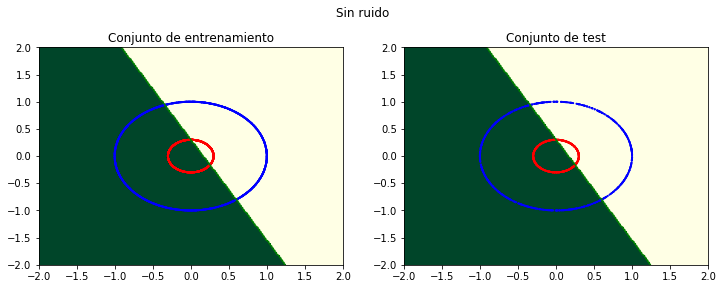

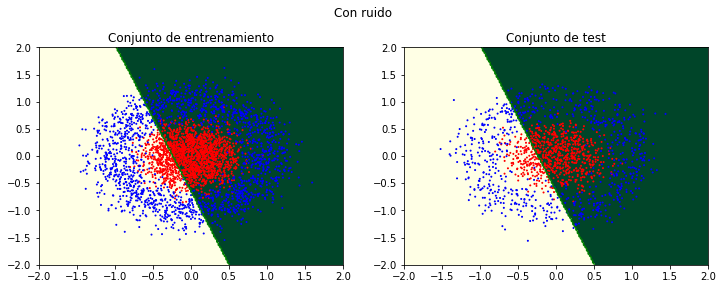

In [6]:
plt.rcParams["figure.figsize"]=[12,4]
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0, 0.3, 1)
clf=LogisticRegression(solver="lbfgs")
clf.fit(x_tr, y_tr)
plot_classifier(clf, x_tr, y_tr, x_tst, y_tst,'Sin ruido')
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0.2, 0.3, 1)
clf=LogisticRegression(solver="lbfgs")
clf.fit(x_tr, y_tr)
plot_classifier(clf, x_tr, y_tr, x_tst, y_tst,'Con ruido')

*Comentario: Se aprecia que el modelo de ajuste de regresión logística aplica una frontera de decisión lineal, siendo natural que con y sin ruido se presenten desempeños semejantes, puesto que mediante este ajuste no es posible encerrar el círculo interior para obtener una predicción de buen desempeño. Al disminuir el ruido igualmente el clasificador clasificará mal una proporción de puntos exteriores inevitablemente, bien con ruido el problema se presentará igualmente. A raíz de esto se ocaciona que el __score__ de la regresión logística se encuentre cercana al 50%*

#### 1.e SVM

Se entrena un clasificador SVM con los datos con ruido.

In [7]:
from sklearn.svm import SVC
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0.2, 0.3, 1)
SV = SVC(C=1, gamma=5)
SV.fit(x_tr,y_tr)
SV.score(x_tst,y_tst)

0.958

*Comentario: Se obtiene el __score__ alto, es decir las predicciones son correctas en un 95% para el dataset de test*

Se procede a graficar la frontera de desición, variando los parámetro C y gamma del ajuste SVM

In [14]:
def plot_sv(X_train, Y_train, X_test, Y_test,d,e,g):
    f, ax = plt.subplots(1, 5, clear=True)
    plt.suptitle(d,y=1.16)
    i=-1
    for axis in ax:
        i+=1
        clf = SVC(C=e[i], gamma=g[i])
        clf.fit(X_train,Y_train)
        XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
        Z = Z.reshape(XX.shape) # for consistency
        Zplot = Z > 0.5 # to separate both classes
        axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axis.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
        axis.scatter(X_train[:,0],X_train[:,1],np.logical_not(Y_train),c='blue')
        axis.scatter(X_train[:,0],X_train[:,1],Y_train,c='red')
        axis.set_title('C: '+str(e[i])+'\ngamma: '+str(g[i])+'\nscore: '+str(round(clf.score(X_test,Y_test),4)))
    plt.show()

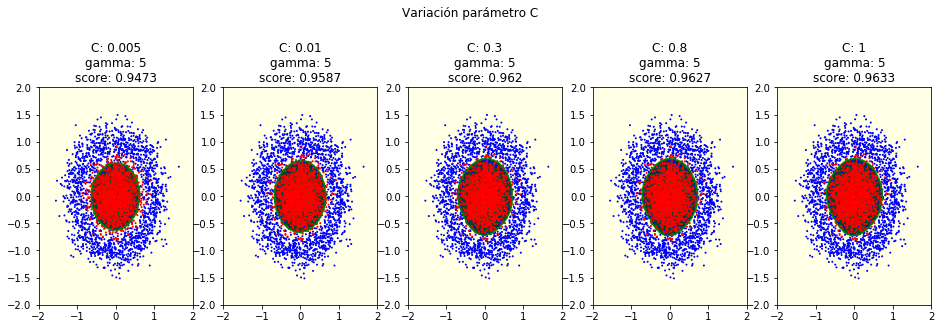

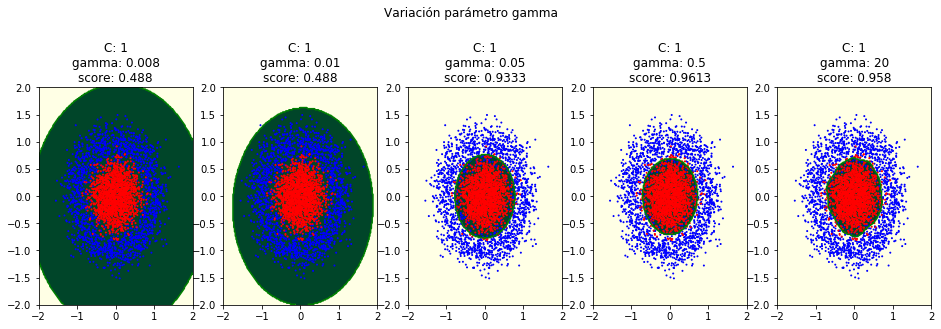

In [15]:
from sklearn.svm import SVC
from matplotlib.colors import BoundaryNorm
plt.rcParams["figure.figsize"]=[16,4]
x_tr,x_tst,y_tr,y_tst=do_circles(5000,0.2, 0.3, 1)
plot_sv(x_tr, y_tr, x_tst, y_tst,'Variación parámetro C',[0.005,0.01,0.3,0.8,1],[5,5,5,5,5])
plot_sv(x_tr, y_tr, x_tst, y_tst,'Variación parámetro gamma',[1,1,1,1,1],[0.008,0.01,0.05,0.5,20])

In [16]:
def plot_sv2(X_train, Y_train, X_test, Y_test,d,e,g):
    f, ax = plt.subplots(1, 2, clear=True)
    plt.suptitle(d,y=1.02)
    i=-1
    for axis in ax:
        i+=1
        clf = SVC(C=e[i], gamma=g[i])
        clf.fit(X_train,Y_train)
        XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
        Z = Z.reshape(XX.shape) # for consistency
        Zplot = Z > 0.5 # to separate both classes
        axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axis.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
        axis.scatter(X_train[:,0],X_train[:,1],Y_train,c='red')
        axis.scatter(X_train[:,0],X_train[:,1],np.logical_not(Y_train),c='blue')
        axis.set_title('C: '+str(e[i])+'\ngamma: '+str(g[i])+'\nscore: '+str(round(clf.score(X_test,Y_test),4)))
    plt.show()

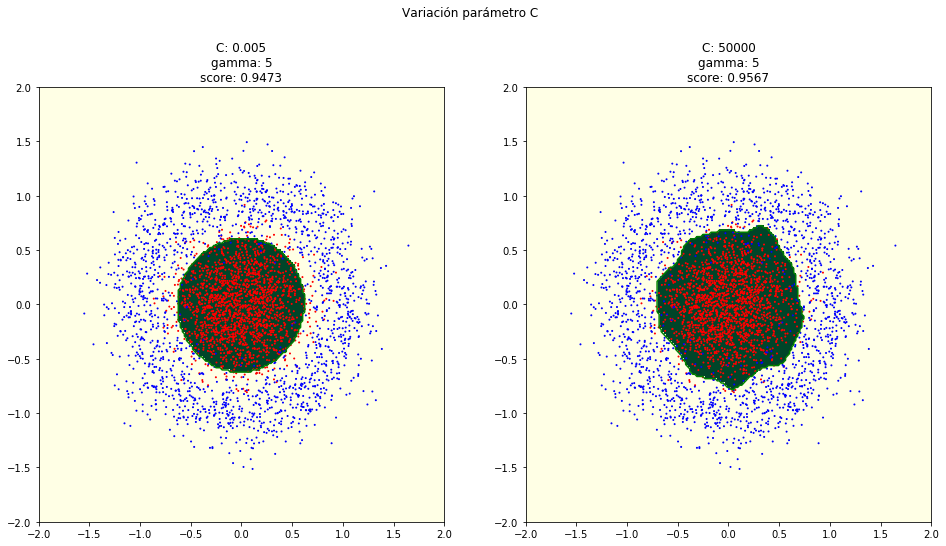

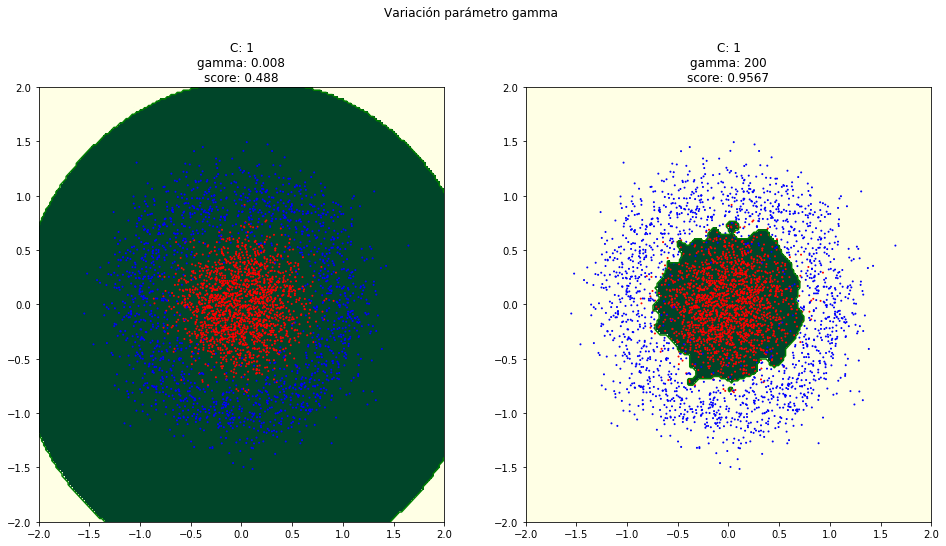

In [17]:
plt.rcParams["figure.figsize"]=[16,8]
plot_sv2(x_tr, y_tr, x_tst, y_tst,'Variación parámetro C',[0.005,50000],[5,5])
plot_sv2(x_tr, y_tr, x_tst, y_tst,'Variación parámetro gamma',[1,1],[0.008,200])

*Comentario: Se aprecia que la frontera de decisión es no lineal pudiéndose encerrar circularmente la circunferencia interior, lográndose un alto __score__ gracias a esto. <br><br>*
*Comentario: El parámetro __C__ es el parámetro de penalización de los errores de clasificación, este controla el trade-off entre el tamaño del margen y los errores de clasificación. Es decir... Para valores grandes de C la SVM optará por escoger hiperplanos con menor tamaño de margen de manera que se puedan clasificar la mayor cantidad de puntos de entrenamiento correctamente. En el caso contrario, para valores pequeños de C ocurrirá que la SVM buscará margenes de mayor tamaño aunque se clasifiquen incorrectamente una cantidad mayor de puntos. Es por esto que al disminuir el valor C la frontera se torna más pequeña, dando lugar a un margen de mayor tamaño. A la vez el parámetro C controlará la suavidad de la frontera de decisión, esto en pos de obtener bajos errores de clasificación en el conjunto de entrenamiento.<br><br>*
*Comentario: El parámetro __gamma__ también permite controlar la suavidad de la frontera de decisión. Este parámetro define qué tanta influencia alcanza un ejemplo de entrenamiento por si solo, con valores bajos significando: "mucha influencia" y valores alto: "baja influencia". Este parámetro puede ser visto como la inversa de el radio de influencia de las muestras seleccionadas por el modelo como vectores de soporte. Para valores de __gamma__ muy grandes el radio del área de influencia de los vectores de soporte sólo incluirán a los vectores de soporte por si mismos, provocándose sobreajuste. Para valores de __gamma__ muy bajos el modelo está restringido y no podrá capturar la complejidad de la data, la región de influencia de los vectores de soporte, sea cual sea el escogido por el modelo, incluirá toda la data de entrenamiento.*

#### 1.f KNN
Se prueba ahora con otro método no lineal, _K nearest neighbors_ o KNN.

In [26]:
def plot_knn(X_train, Y_train, X_test, Y_test,d,e,g):
    f, ax = plt.subplots(1, 5, clear=True)
    plt.suptitle(d,y=1.16)
    i=-1
    for axis in ax:
        i+=1
#         clf = SVC(C=e[i], gamma=g[i])
        clf=KNeighborsClassifier(n_neighbors=e[i], p=g[i])
        clf.fit(X_train,Y_train)
        XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
        Z = Z.reshape(XX.shape) # for consistency
        Zplot = Z > 0.5 # to separate both classes
        axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axis.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
        axis.scatter(X_train[:,0],X_train[:,1],np.logical_not(Y_train),c='blue')
        axis.scatter(X_train[:,0],X_train[:,1],Y_train,c='red')
        axis.set_title('n__neighbors: '+str(e[i])+'\np: '+str(g[i])+'\nscore: '+str(round(clf.score(X_test,Y_test),4)))
    plt.show()

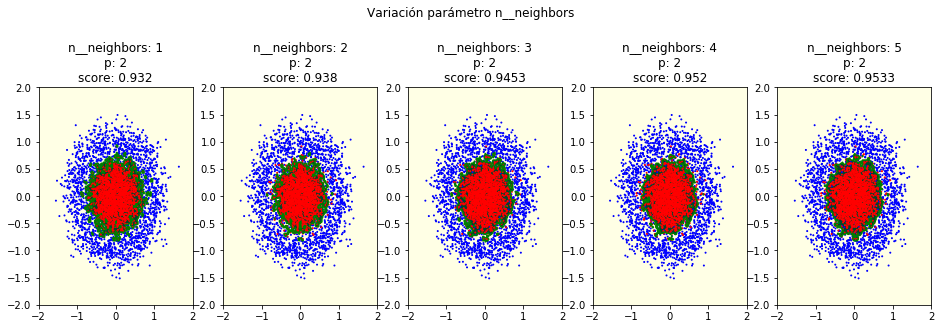

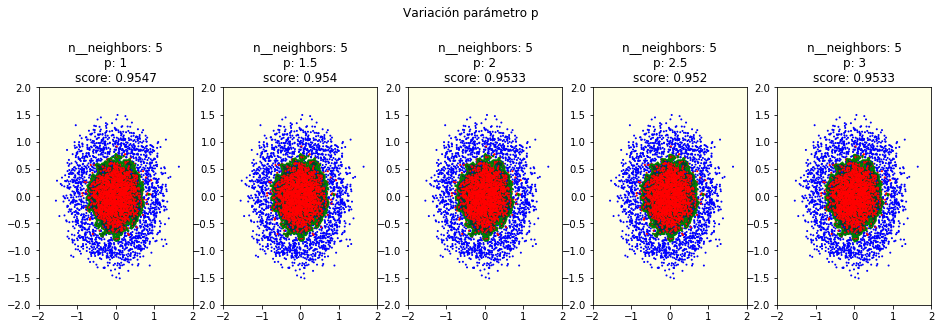

In [27]:
from sklearn.neighbors import KNeighborsClassifier
plt.rcParams["figure.figsize"]=[16,4]
plot_knn(x_tr, y_tr, x_tst, y_tst,'Variación parámetro n__neighbors',[1,2,3,4,5],[2,2,2,2,2])
plot_knn(x_tr, y_tr, x_tst, y_tst,'Variación parámetro p',[5,5,5,5,5],[1,1.5,2,2.5,3])

In [28]:
def plot_knn2(X_train, Y_train, X_test, Y_test,d,e,g):
    f, ax = plt.subplots(1, 2, clear=True)
    plt.suptitle(d,y=1.02)
    i=-1
    for axis in ax:
        i+=1
#         clf = SVC(C=e[i], gamma=g[i])
        clf=KNeighborsClassifier(n_neighbors=e[i], p=g[i])
        clf.fit(X_train,Y_train)
        XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
        Z = Z.reshape(XX.shape) # for consistency
        Zplot = Z > 0.5 # to separate both classes
        axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
        axis.contour(XX, YY, Zplot, alpha=1, colors=["g"], linestyles=["-"], levels=[0.5])
        axis.scatter(X_train[:,0],X_train[:,1],np.logical_not(Y_train),c='blue')
        axis.scatter(X_train[:,0],X_train[:,1],Y_train,c='red')
        axis.set_title('n__neighbors: '+str(e[i])+'\np: '+str(g[i])+'\nscore: '+str(round(clf.score(X_test,Y_test),4)))
    plt.show()

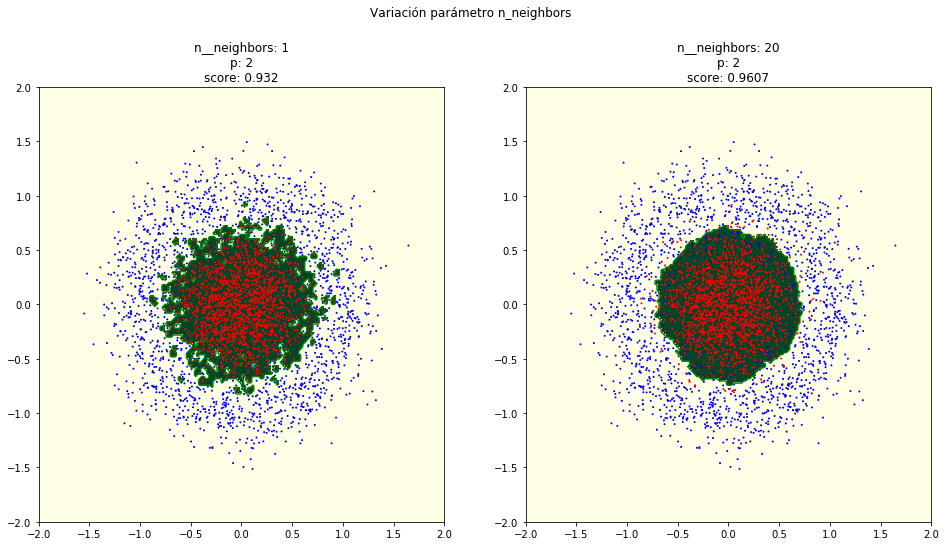

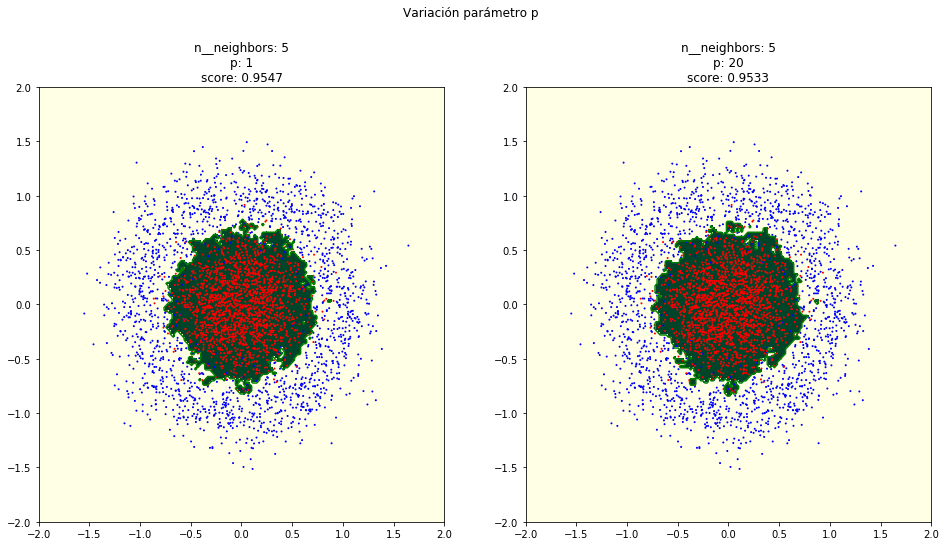

In [80]:
plt.rcParams["figure.figsize"]=[16,8]
plot_knn2(x_tr, y_tr, x_tst, y_tst,'Variación parámetro n_neighbors',[1,20],[2,2])
plot_knn2(x_tr, y_tr, x_tst, y_tst,'Variación parámetro p',[5,5],[1,20])

El algoritmo KNN consiste en el uso de la distancia entre los puntos de entrenamiento en el espacio multidimensional en que se encuentran de acuerdo a la métrica Minkowski, de acuerdo a esta distancia para cada punto que se desee predecir se buscarán los n_neighbors puntos más cercanos y se etiquetará a este punto de acuerdo a la etiqueta más frencuente de estos n_neighbors puntos (votación).<br><br>
De acuerdo a esto podemos definir la utilidad de los parámetros utilizados:

*Comentario: El parámetro n_neighbors representa el número de vecindarios que utilizará el método KNN, utilizar un n_neighbors=1 significará que cada muestra se utiliza a si misma como referencia, lo cual llegará a provocar overfitting, luego al utilizar un valor elevado será posible ver que se producirán menores cantidades de "islas" en la frontera de decisión, que por si sola es altamente no-lineal y no necesariamente continua.*

*Comentario: El parámetro p en el método KNN hace referencia a la potencia a la que se encontrará elevada la métrica Minkowski, la cual se utilizará para calcular la distancia entre puntos. Para p=1, es equivalente a utilizar la distancia manhattan (l1), y para p=2 es equivalente a la distancia euclidiana (l2). Por lo tanto no se aprecian grandes cambios visualmente al utilizar la métrica l1 o l20, aún así si se ve que existe un efecto en el score obtenido.*

Se realiza cross validation para ambos parámetros

In [81]:
x_data=np.concatenate((x_tr,x_tst))
y_data=np.concatenate((y_tr,y_tst))
xy_data=np.concatenate((x_data,y_data.reshape(y_data.shape[0],1)),axis=1)
p_n=np.linspace(1,5,5,dtype=int)
n_n=np.linspace(1,50,50,dtype=int)
n_model=[]
p_model=[]
from sklearn.model_selection import KFold
folds = KFold(10)
prommodels=[]
for pi in p_n:
    for ni in n_n:
        infold=[]
        for train_index, val_index in folds.split(xy_data):
            KNN = KNeighborsClassifier(n_neighbors=ni, p=pi)
            KNN.fit(xy_data[train_index,0:2], xy_data[train_index,2])
            infold.append(KNN.score(xy_data[val_index,0:2], xy_data[val_index,2]))
            if len(infold)==10:
                prommodels.append(sum(infold)/10)
                n_model.append(ni)
                p_model.append(pi)
index=np.argmax(np.asarray(prommodels))
print("Best model parameters: ( n_neighbors=",n_model[index],"), ( p=",p_model[index],"), Score: ",prommodels[index])
index=np.argmin(np.asarray(prommodels))
print("Worst model parameters: ( n_neighbors=",n_model[index],"), ( p=",p_model[index],"), Score: ",prommodels[index])

Best model parameters: ( n_neighbors= 41 ), ( p= 1 ), Score:  0.9560000000000001
Worst model parameters: ( n_neighbors= 2 ), ( p= 3 ), Score:  0.9314


*Comentario: Se aprecia que el método cross-validation permite obtener tanto el mejor como peor modelo en el espacio de búsqueda, existiendo una diferencia de aproximadamente 2% entre ambos modelos (__score__).*

#### 1.g
Del mejor modelo obtenido en el punto anterior, se grafican los datos de test coloreando en rojo los puntos mal clasificados por el modelo y en verde los bien clasificados.

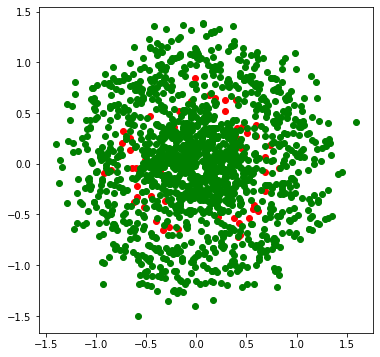

In [88]:
best_model = KNeighborsClassifier(n_neighbors=41, p=1)
best_model.fit(x_tr,y_tr)
predictions = best_model.predict(x_tst)
correct_predictions = predictions == y_tst
plt.figure(figsize=(6, 6))
axis = plt.axes()
XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
# plot correct predictions as green points and incorrect ones as red points
axis.scatter(x_tst[correct_predictions==0][:,0], x_tst[correct_predictions==0][:,1], c="r")
axis.scatter(x_tst[correct_predictions==1][:,0], x_tst[correct_predictions==1][:,1], c="g")
plt.show()

*Comentario: El modelo falla en clasificar estos puntos que se ubican dentro del umbral en que existen datos pertenecientes a ambas clases de acuerdo a la votación que se realiza, dada la coexistencia de datos de ambas etiquetas la votación puede resultar desfavorable*

*Comentario: Al utilizar datos sin ruidos no existiría este inconveniente puesto no existirá este umbral, lo cual se demuestra a continuación*

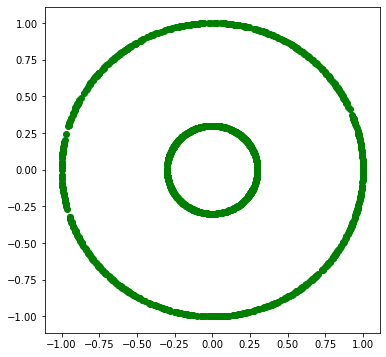

In [89]:
x_trd,x_tstd,y_trd,y_tstd=do_circles(5000,0, 0.3, 1)
best_model = KNeighborsClassifier(n_neighbors=41, p=1)
best_model.fit(x_trd,y_trd)
predictions = best_model.predict(x_tstd)
correct_predictions = predictions == y_tstd
plt.figure(figsize=(6, 6))
axis = plt.axes()
XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
# plot correct predictions as green points and incorrect ones as red points
axis.scatter(x_tstd[correct_predictions==0][:,0], x_tstd[correct_predictions==0][:,1], c="r")
axis.scatter(x_tstd[correct_predictions==1][:,0], x_tstd[correct_predictions==1][:,1], c="g")
plt.show()

#### 1.h Metodo Kernel
Utilizaremos Kernel Gaussiano para preprocesar los datos, pasando implícitamente por un espacio altamente dimensional (más especificamente por un _manifold_ de un espacio infinito dimensional), obteniendo una representación lo más linealmente separable posible.

In [102]:
from sklearn.decomposition import KernelPCA
ker = KernelPCA(2, kernel='rbf', gamma=5)
ker.fit(x_tr)
X_ker_train = ker.transform(x_tr)

Se ajusta el kernel y transforman los datos. Se procede a graficar los puntos transformados.

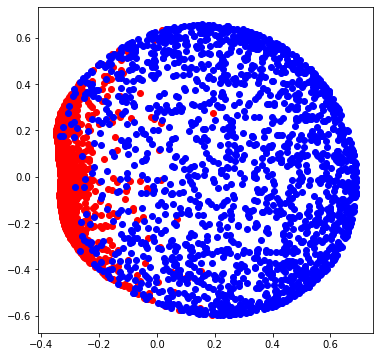

In [103]:
plt.figure(figsize=(6,6))
axis = plt.axes()
XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
axis.scatter(X_ker_train[y_tr==0][:,0], X_ker_train[y_tr==0][:,1], c="r")
axis.scatter(X_ker_train[y_tr==1][:,0], X_ker_train[y_tr==1][:,1], c="b")
plt.show()

*Comentario: Se aprecia que la transformación mediante el kernel gaussiano con los parámetros utilizados no es lo suficientemente exitosa para provocar que los datos sean linealmente separable obteniéndose un buen __score__, puesto existe aún un umbral en el que existen datos coexistentes con ambas etiquetas.*

Se procede a variar el valor de gamma

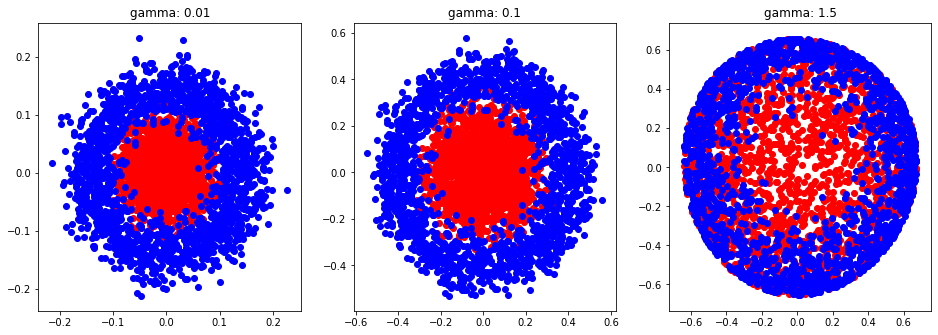

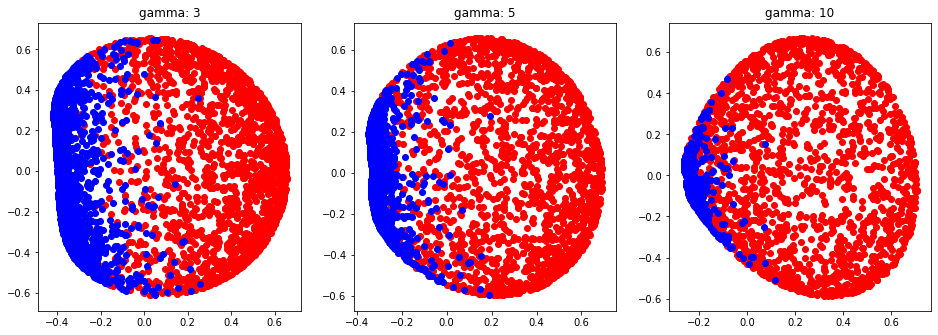

C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


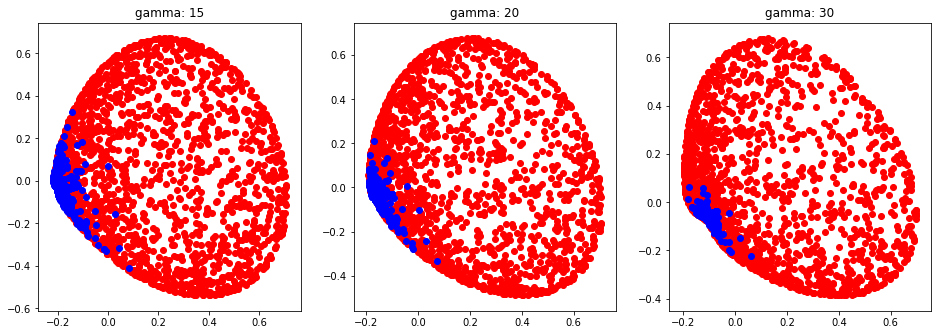

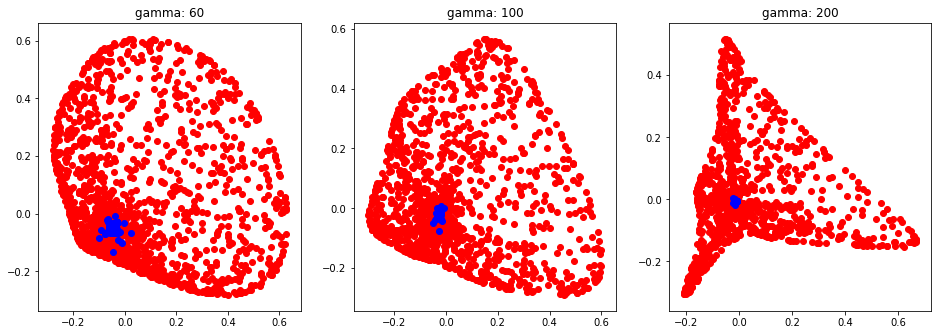

In [119]:
gamma_values = [0.01,0.1,1.5,3,5,10,15,20,30,60,100,200]
i=-1
plt.rcParams["figure.figsize"]=[16,5.3]
for gamma in gamma_values:
    if i ==-1:
        f, ax = plt.subplots(1, 3, clear=True)
    i+=1
    ker = KernelPCA(2, kernel='rbf', gamma=gamma)
    ker.fit(x_tr)
    X_ker_train = ker.transform(x_tr)
    axis = ax[i]
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    axis.set_title('gamma: '+str(gamma))
    axis.scatter(X_ker_train[y_tr==1][:,0], X_ker_train[y_tr==1][:,1], c="r")
    axis.scatter(X_ker_train[y_tr==0][:,0], X_ker_train[y_tr==0][:,1], c="b")
    if i==2:
        i=-1
        plt.show()

*Comentario: Al variar el valor de gamma, podemos observar que los datos se deforman más respecto a su forma original mientras mayor sea el valor de gamma, para valor pequeños los datos se ven bastante parecidos a los creados originalmente. Además se aprecia que para valores de gamma muy altos, la clase correspondiente a la circunferencia exterior tiende a colapsar a un punto.* <br><br>

*Comentario: Mientras aumentamos el valor de gamma, podemos observar un comportamiento distinto de los datos de cada clase, estos comienzan a separarse. Si bien se podrían volver a utilizar estos nuevos datos transformados para plantear un modelo distinto, solo viendo estas figuras no podemos afirmar que este modelo tendrá mejor desempeño que los modelos anteriores, esto ya que no podemos ver una clara diferenciación entre las clases, aun menos una frontera lineal.*<br><br>

Se procede a realizar un modelo de regresión logística para un gamma equivalente a 15, la cual a simple vista parece generar una separación más lineal que los demás valores de gamma con que se experimentó

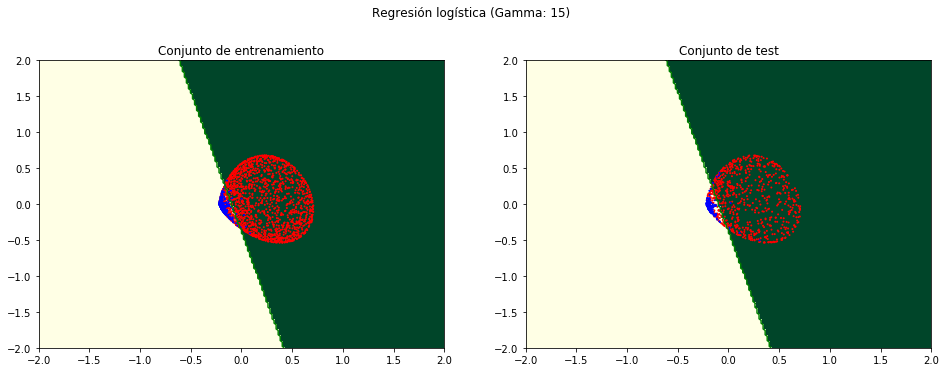

Score regresión logística: 0.9166666666666666


In [124]:
ker = KernelPCA(2, kernel='rbf', gamma=15)
ker.fit(x_tr)
X_train_transformed = ker.transform(x_tr)
X_test_transformed = ker.transform(x_tst)
log_reg = LogisticRegression(solver='lbfgs')
clf=log_reg.fit(X_train_transformed, y_tr)
plot_classifier(log_reg, X_train_transformed, y_tr, X_test_transformed, y_tst,"Regresión logística (Gamma: 15)")
print("Score regresión logística:", log_reg.score(X_test_transformed, y_tst))

*Comentario: Claramente el score mejora por sobre la regresión logística planteada inicialmente, puesto a que los datos de la clase coloreada de azul estan acumulados en solo un extremo de la figura formada por los datos transformados, teniendo mayor fundamento utilizar una frontera de decisión lineal.*<br><br>

*Comentario: Si bien el score aumenta considerablemente, este sigue siendo menor a los obtenidos por otros modelos clasificadores SVM o K Nearest Neighors. Además claramente podemos ver que la frontera de decisión realizará muchas predicciones erroneas.*

A continuación se muestra la matriz de confusión de la regresión logística para el conjunto de test

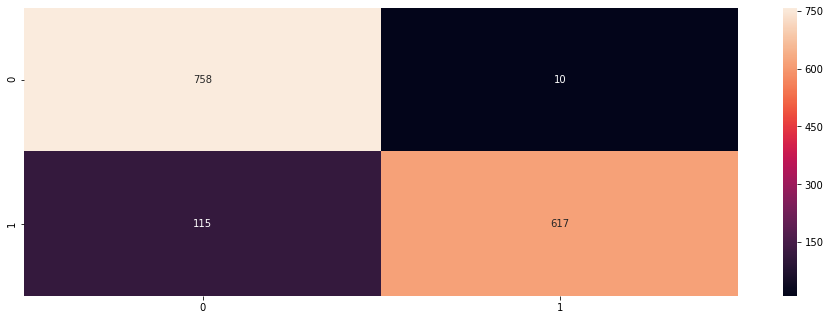

In [126]:
import seaborn as sns
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_tst, log_reg.predict(X_test_transformed))
sns.heatmap(confusion_matrix,annot=True,fmt='d')
plt.show()

*Comentario: En el eje x se muestra la predicción realizada, siendo posible reconocer que la regresión logística se equivoca mayoritariamente diciendo que un dato a predecir es perteneciente al círculo exterior (azul) cuando en verdad pertenece al círculo interior (rojo), lo cual calza con la visualización brindada anteriormente*

#### 1.i Manualmente
Como nosotros conocemos como se generaron los datos tenemos una ventaja sobre los modelos. Se procede a generar una transformación de los datos para obtener datos linealmente separables. 

Se hace uso de las propiedades trigonométricas con las que se formaron los circulos a partir de una función coseno y seno.

In [135]:
def transform_data(X):
    
    new_data = np.zeros((X.shape[0], 3))
        
    # Feature 1 al cuadrado
    new_data[:,0] = np.square(X[:,0])
    
    # Raiz de 2 por feature1 por feature2
    new_data[:,1] = np.sqrt(2) * X[:,0] * X[:,1]
    
    # Feature 2 al cuadrado
    new_data[:,2] = np.square(X[:,1])
    
    return new_data
X_train_3D = transform_data(x_tr)
X_test_3D = transform_data(x_tst)

La generación de círculos (generación de data) inicia con la generación de una circunferencia (x,y) a partir de la transformación (cos(t),sen(t)), donde t es un valor entre 0 y 2$\pi$, luego para diferenciar círculo interior y exterior se utiliza una vulgar multiplicación a (x,y), resultando la circunferencia exterior: $(c_1\cdot x,c_1\cdot y)$ y la circunferencia exterior: $(c_2\cdot x,c_2\cdot y)$. Finalmente a ambas circunferencias se les aplica ruido normal.<br>

La transformación propuesta es: $x*=x^2$, $y*=\sqrt{2}\cdot x\cdot y$ y $z*=y^2$, lo cual equivale a $x*=c^2\cdot cos^2(t)$, $y*=\sqrt{2}\cdot c^2\cdot cos(t)\cdot sen(t)$ y $z*=c^2\cdot sen^2(t)$, donde $c\in[c_1,c_2]$

Luego el valor $c$, el cual es una medida del radio de la circunferencia se verá aumentado en las 3 dimensiones a las cuales se transformó el problema. A continuación la representación gráfica:

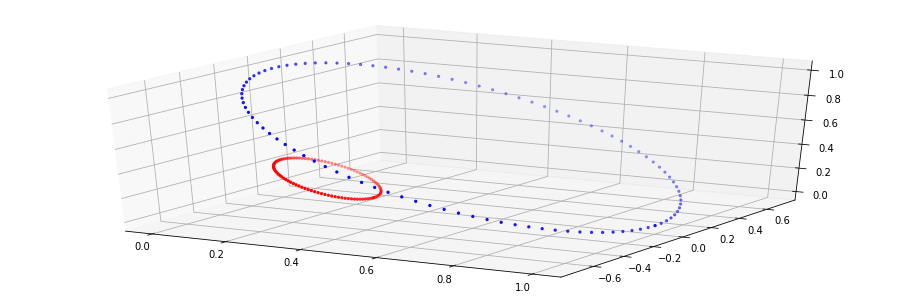

In [152]:
from mpl_toolkits.mplot3d import Axes3D
t=np.linspace(0,2*np.pi,100)
xx=np.cos(t)
yy=np.sin(t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx*xx, np.sqrt(2)*yy*xx, yy*yy, marker='.',color='b')
xx,yy=0.5*xx,0.5*yy
ax.scatter(xx*xx, np.sqrt(2)*yy*xx, yy*yy, marker='.',color='r')
plt.show()

Ahora aplicada a la data de entrenamiento, la cual contiene ruido:

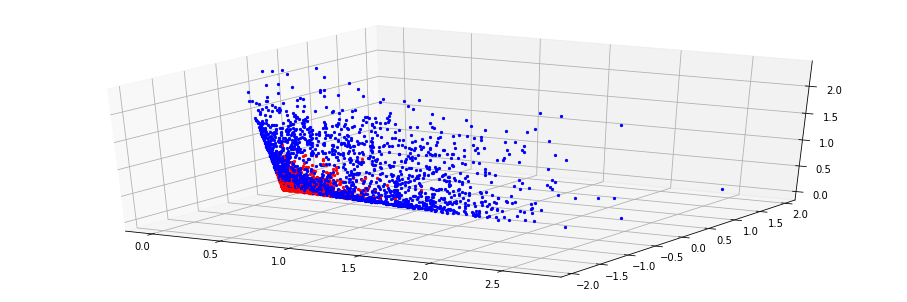

In [156]:
from mpl_toolkits.mplot3d import Axes3D
t=np.linspace(0,2*np.pi,100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for dot in range(x_tr.shape[0]):
    if y_tr[dot]==0:
        ax.scatter(x_tr[dot,0]*x_tr[dot,0], np.sqrt(2)*x_tr[dot,1]*x_tr[dot,0], x_tr[dot,1]*x_tr[dot,1], marker='.',color='b')
    if y_tr[dot]==1:
        ax.scatter(x_tr[dot,0]*x_tr[dot,0], np.sqrt(2)*x_tr[dot,1]*x_tr[dot,0], x_tr[dot,1]*x_tr[dot,1], marker='.',color='r')
plt.show()

*Comentario: Se aprecia que se logra una transformación exitosa, pues una separación lineal de los datos mostrados parece apropiada a simple vista*

In [157]:
log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X_train_3D, y_tr)
log_reg.score(X_test_3D, y_tst)

0.9586666666666667

*Comentario: Se obtiene un score alto, lo cual confirma que la transformación a una dimensión superior resulta útil para separar linealmente los datos. Claro que se contaba con la función que generaba la data de entrenamiento, lo cual es prácticamente imposible de conseguir en la vida real y por lo cual no es sencillo de aplicar el método de Kernel, teniendo que realizar cross-validation para dar con la transformación más adecuada.*

A continuación se muestra la matriz de confusión:

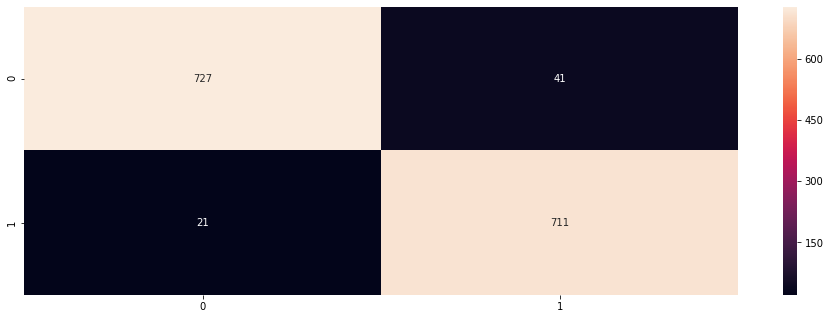

In [158]:
import seaborn as sns
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_tst, log_reg.predict(X_test_3D))
sns.heatmap(confusion_matrix,annot=True,fmt='d')
plt.show()

*Comentario: Se aprecio baja cantidad de errores en la predicción y una tendencia no tan marcada a predecir que los datos pertenecen a la clase de circunferencia exterior cuando en realidad pertenecen a la clase de la circunferencia interior*

<a id="tercero"></a>
## 2. Regularización para regresión. 

Un problema que podemos encontrar transversalmente a todos los modelos es el problema del _overfitting_. Este problema consiste en un modelo que aprende demasiado bien los datos de ejemplo o entrenamiento, al punto que al momento de ver ejemplos desconocidos o de validación, baja su desempeño respecto a un modelo "menos entrenado". En algunos casos podriamos decir que el modelo "aprende de memoria" los ejemplos, en vez de intentar obtener información generalizable a partir de su entrenamiento. Para el caso de la regresión, una de las aproximaciones más comunes para tratar de mitigar este efecto es el de la regularización. Agregando una penalización a la norma de los parametros de la regresión podemos restringir la eficiencia del modelo al momento de aprender los datos de entrenamiento, incluso forzando dependiendo de la intensidad de la regularización que algunos parametros se vuelvan cero. 

<img src="https://pngimage.net/wp-content/uploads/2018/06/house-for-sale-sign-png-6.png"  style="height:13.9cm;"  />

En esta pregunta utilizaremos nuevamente la base de datos de precios de casas en King County, https://www.kaggle.com/harlfoxem/housesalesprediction, que utilizamos en la Tarea 1. Utilizaremos estos datos ya conocidos y analizados anteriormente para enfocarnos en la regularización para regresión. Exploraremos como varian los distintos errores de predicción y como cambian los valores de los parámetros ajustados por el modelo para distintos valores del coeficiente de regularización, para tratar de entender que ocurre con las distintas regularizaciones y sus diferencias. 

#### 2.a Carga y preprocesamiento.
Se cargan y preprocesan los datos de la misma forma en que lo realizó en la tarea 1, incluyendo estandarizar el _target_. Se utiliza 0.5 de los datos como _training set_, 0.3 como _validation set_ y 0.2 como _test set_.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [28]:
data = pd.read_csv("kc_house_data.csv")
def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res
data['date'] = data.date.apply(to_num).rank()
data=data.drop(columns=['id','zipcode'])
data=data.drop(np.argmax(data['bedrooms'])) # eliminar outlier de 30 y tantas piezas
# transformaciones hechas en la tarea 1 pregunta 2
no_norm=['price','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
discr=['bedrooms','bathrooms','view','grade']
norm=list(set(data.columns)-set(no_norm)-set(['yr_renovated'])-set(['waterfront'])-set(discr)-set(['long']))
data_norm=data.copy()
for i in data.columns:
    if i in no_norm:
        data_norm[i]=np.log(data[i]+1)
    if i in norm:
        data_norm[i]=(data[i]-np.std(data[i]))/np.mean(data[i])
    if i=='yr_renovated':
        data_norm[i]=(data['yr_renovated']>1)*1
    if i in discr:
        data_norm[i]=data[i]/np.max(data[i])
    if i=='long':
        data_norm[i]=(data[i]-np.max(data[i]))/(np.max(data[i])-np.min(data[i]))
data_norm_pick=data_norm.copy()
data_norm_pick=data_norm_pick.drop(columns=['yr_built','long','condition'])
y = data_norm_pick["price"]
X = data_norm_pick.drop(columns=["price"])
x_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.5)
x_val, x_tst, y_val, y_tst = train_test_split(X_tmp, y_tmp, test_size=0.4)
print("training set size: ", x_tr.shape[0]/X.shape[0], "\nvalidation set size: ", x_val.shape[0]/X.shape[0], "\ntest set size: ", x_tst.shape[0]/X.shape[0])

training set size:  0.5 
validation set size:  0.29997223764575237 
test set size:  0.20002776235424763


#### 2.b Modelo sin regularización
Se entrena un modelo de regresión lineal no regularizado con los datos preprocesados.

In [29]:
reg = LinearRegression()
reg.fit(x_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Se calcula el error cuadrático medio (MSE) del modelo para el conjunto de entrenamiento, validación y test. 

In [30]:
reg_train_err = mean_squared_error(y_tr, reg.predict(x_tr))
reg_val_err = mean_squared_error(y_val, reg.predict(x_val))
reg_test_err = mean_squared_error(y_tst, reg.predict(x_tst))
print("Training error:", reg_train_err)
print("Validation error:", reg_val_err)
print("Test error:", reg_test_err)

Training error: 0.0717904324019669
Validation error: 0.07293968773878394
Test error: 0.07242313257187001


#### 2.c Regularización
Discusión regularización ¿_Lasso_ y _Ridge_? 

*Comentario: La regularización busca que los parámetros entrenables del modelo tengan valores menores, esto se logra por medio de la incorporación de una penalización a cada uno de los parámetros en la función a minimizar. El objetivo de esto es remediar el overfitting que pueda estar sufriendo el modelo.* <br><br>

*El parámetro de regularización $\lambda$ acompañará la penalización en la función objetivo como un escalar que multiplica los parámetros según una norma ($L^1$, $L^2$, etc..), La diferencia entre regularización de Lasso y Ridge recae en que la penalización se aplica sobre el cuadrado de los parámetros ($L^2$: Ridge) o sobre el valor absoluto de los parámetros ($L^1$: Lasso). Matemáticamente la incorporación de la regularización mediante Ridge provocará que la función a minimizar (función de pérdida) sea: $L_{ridge}(\hat{\beta})=\sum_{i=1}^{n}(y_i-x'_i\hat{\beta})^2+\lambda \sum_{j=1}^{m}\hat{\beta}^2$, mientras Lasso se incorpora del siguiente modo: $L_{lasso}(\hat{\beta})=\sum_{i=1}^{n}(y_i-x'_i\hat{\beta})^2+\lambda \sum_{j=1}^{m}|\hat{\beta}|$* <br><br>

*Utilizar diferentes normas influirá en cómo se llevará a cabo la penalización, puesto Ridge tenderá a reducir los valores de los parámetros entrenables del modelo a valores cercanos a 0 sin anularlos, mientras que Lasso provocará que los parámetros con poca relevancia tiendan a tomar el valor 0, esto terminará por reducir el número de features que teníamos inicialmente en nuestro modelo a algún número menor.* <br><br>

*El valor que se asigne a $\lambda$ indicará la influencia que tendrá la penalización en la función objetivo. Por lo tanto valores mayúsculos de el valor $\lambda$ provocarían que durante el proceso de entrenamiento el modelo opte por minimizar los valores de los parámetros entrenables en lugar de minimizar el error, dado que ambos forman parte de la función objetivo a minimizar. Caso contrario, si $\lambda$ es demasiado pequeño, la regularización no tendrá mayor impacto en los parámetros entrenables del modelo (seguirá el riesgo de que el modelo experimente overfitting) y si es muy grande, no se podrá encontrar un óptimo que satisfaga bien incluso en el conjunto de entrenamiento (el modelo sufrirá de underfitting).*<br><br>

#### 2.d Influencia sobre el error
Se grafica cómo varia el error de entrenamiento y el error de validación a medida que se cambia el valor del parámetro $\lambda$.

Inicialmente con __Lasso__:

In [31]:
lasso_train_errors = []
lasso_val_errors = []
lasso_space = pd.np.logspace(-10,-0.01,100)
for lambd in lasso_space:
    model = Lasso(alpha=lambd)
    model.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, model.predict(x_tr))
    lasso_train_errors.append(train_err)
    val_err = mean_squared_error(y_val, model.predict(x_val))
    lasso_val_errors.append(val_err)    

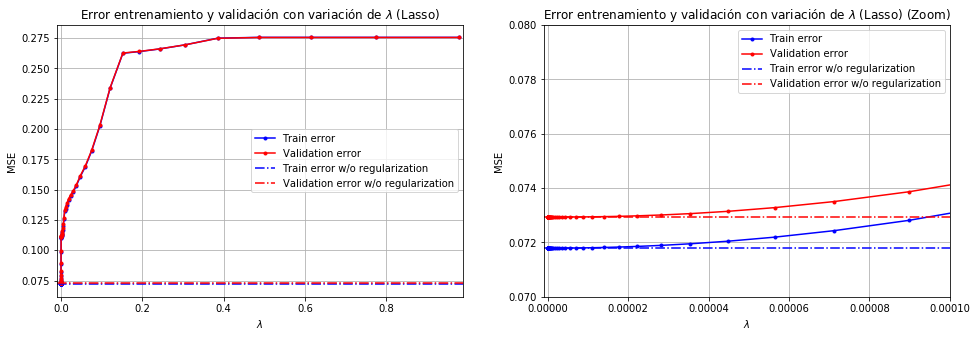

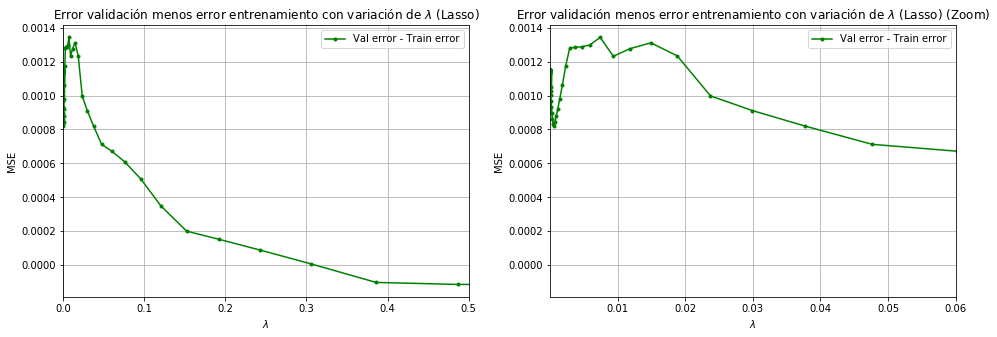

In [62]:
fig = plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.title("Error entrenamiento y validación con variación de $\lambda$ (Lasso)")
plt.plot(lasso_space, lasso_train_errors, "b.-",label="Train error")
plt.plot(lasso_space, lasso_val_errors, "r.-",label="Validation error")
plt.axhline(y=reg_train_err,color='b',linestyle='-.',label='Train error w/o regularization')
plt.axhline(y=reg_val_err,color='r',linestyle='-.',label='Validation error w/o regularization')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.xlim([lasso_space[0]-0.01,lasso_space[-1]+0.01])
plt.subplot(1,2,2)
plt.title("Error entrenamiento y validación con variación de $\lambda$ (Lasso) (Zoom)")
plt.plot(lasso_space, lasso_train_errors, "b.-",label="Train error")
plt.plot(lasso_space, lasso_val_errors, "r.-",label="Validation error")
plt.axhline(y=reg_train_err,color='b',linestyle='-.',label='Train error w/o regularization')
plt.axhline(y=reg_val_err,color='r',linestyle='-.',label='Validation error w/o regularization')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.ylim([0.07,0.08])
plt.xlim([lasso_space[0]-0.000001,lasso_space[0]+0.0001])
plt.show()
fig = plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.title("Error validación menos error entrenamiento con variación de $\lambda$ (Lasso)")
plt.plot(lasso_space, np.asarray(lasso_val_errors)-np.asarray(lasso_train_errors), "g.-",label="Val error - Train error")
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
# plt.ylim([0.07,0.08])
plt.xlim([lasso_space[0]-0.000001,0.5])
plt.subplot(1,2,2)
plt.title("Error validación menos error entrenamiento con variación de $\lambda$ (Lasso) (Zoom)")
plt.plot(lasso_space, np.asarray(lasso_val_errors)-np.asarray(lasso_train_errors), "g.-",label="Val error - Train error")
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
# plt.ylim([0.07,0.08])
plt.xlim([lasso_space[0],lasso_space[0]+0.06])
plt.show()

*Comentario: Se aprecia que a medida que aumenta la influencia de la penalización por norma Lasso empeora el error del modelo, para un valor de $\lambda$ de aproximadamente 0.4 el modelo converge a un error de entrenamiento y validación dado que los coeficientes del modelo son llevados a cero. También se ve que las curvas de error muestran quiebres a medida que aumenta lambda, lo cual ha de calzar cuando un coeficiente asociado a un atributo alcanza el valor de 0.*<br><br>

*Comentario: Al visualizar la diferencia entre errores de validación y entrenamiento se ve que el uso de la regularización permite variar la diferencia entre estos errores a la vez que varía $\lambda$. Mientras menor sea la diferencia entre ambos errores ha de ser indicio de que no está ocurriendo overfitting.*

Ahora con Ridge

In [52]:
ridge_train_errors = []
ridge_val_errors = []
ridge_space = np.linspace(0.00001,1,100)
for lambd in ridge_space:
    model = Ridge(alpha=lambd)
    model.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, model.predict(x_tr))
    ridge_train_errors.append(train_err)
    val_err = mean_squared_error(y_val, model.predict(x_val))
    ridge_val_errors.append(val_err)    

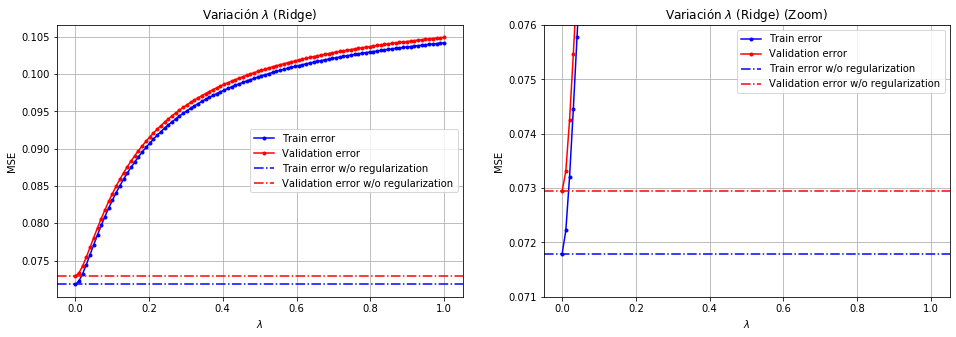

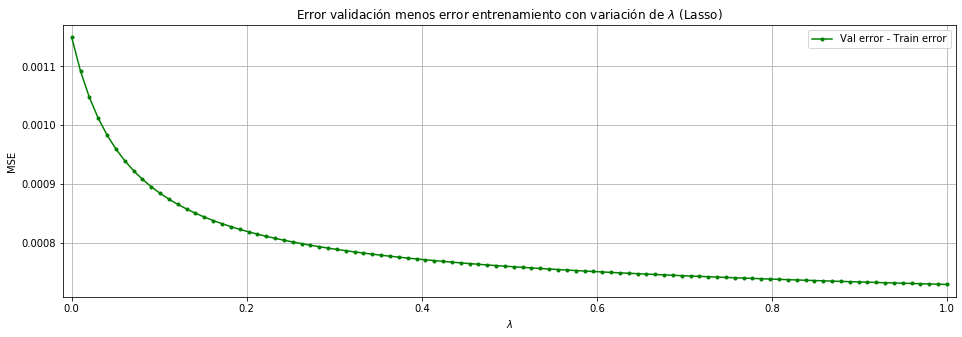

In [63]:
fig = plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.title("Variación $\lambda$ (Ridge)")
plt.plot(ridge_space, ridge_train_errors, "b.-",label="Train error")
plt.plot(ridge_space, ridge_val_errors, "r.-",label="Validation error")
plt.axhline(y=reg_train_err,color='b',linestyle='-.',label='Train error w/o regularization')
plt.axhline(y=reg_val_err,color='r',linestyle='-.',label='Validation error w/o regularization')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
# plt.xlim([ridge_space[0]-0.01,ridge_space[-1]+0.01])
plt.subplot(1,2,2)
plt.title("Variación $\lambda$ (Ridge) (Zoom)")
plt.plot(ridge_space, ridge_train_errors, "b.-",label="Train error")
plt.plot(ridge_space, ridge_val_errors, "r.-",label="Validation error")
plt.axhline(y=reg_train_err,color='b',linestyle='-.',label='Train error w/o regularization')
plt.axhline(y=reg_val_err,color='r',linestyle='-.',label='Validation error w/o regularization')
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.ylim([0.071,0.076])
# plt.xlim([ridge_space[0]-0.01,ridge_space[0]+0.1])
plt.show()
fig = plt.figure(figsize = (16,5))
plt.title("Error validación menos error entrenamiento con variación de $\lambda$ (Lasso)")
plt.plot(ridge_space, np.asarray(ridge_val_errors)-np.asarray(ridge_train_errors), "g.-",label="Val error - Train error")
plt.grid()
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
# plt.ylim([0.07,0.08])
plt.xlim([ridge_space[0]-0.01,ridge_space[-1]+0.01])
plt.show()

*Comentario: Se aprecia también que a medida que aumenta $\lambda$ empeora el rendimiento del modelo dado que aumenta el error, a la vez se ve que la curva que sigue el error a medida que aumenta $\lambda$ es más suave, a diferencia de Lasso que presentaba discontinuidades presumiblemente a medida que features del modelo eran ignoradas a la vez que el respectivo coeficiente que lo acompañaba en el modelo lineal llegaba a cero.*<br><br>
*Comentario: Se visualiza a la vez cómo se va reduciendo la diferencia entre el error de validación y el de entrenamiento a la vez que aumenta la penalización, lo cual indica que efectivamente se evitaría sobre ajuste, aunque el hecho de que aumenten ambos errores resulta inconveniente la aplicación de esta técnica en este caso en específico.*

#### 2.e Influencia sobre los coeficientes
Se grafica ahora como se comporta el valor de los coeficientes del modelo lineal en el modelo entrenado a medida crece $\lambda$, tanto para _Lasso_ como para _Ridge_. Para esto se entrena un modelo para cada valor de $\lambda$ y se guardan sus coeficientes.

In [64]:
space = pd.np.logspace(-3.3,-0.4,100)
coefs = []
for lambd in space:
    model = Lasso(alpha=lambd)
    model.fit(x_tr, y_tr)
    coefs.append(model.coef_)

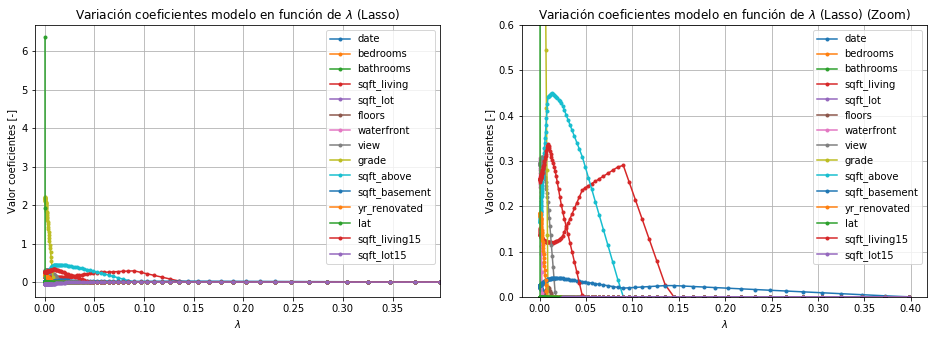

In [67]:
plt.rcParams["figure.figsize"]=[16,5]
plt.subplot(1,2,1)
plt.title("Variación coeficientes modelo en función de $\lambda$ (Lasso)")
for y_arr, label in zip(pd.np.squeeze(coefs).T, x_tr.columns):
    plt.plot(space, y_arr,'.-', label=label)
plt.legend(loc="upper right")
plt.grid()
plt.ylabel("Valor coeficientes [-]")
plt.xlabel("$\lambda$")
plt.xlim([-0.01,space[-1]])
plt.subplot(1,2,2)
plt.title("Variación coeficientes modelo en función de $\lambda$ (Lasso) (Zoom)")
for y_arr, label in zip(pd.np.squeeze(coefs).T, x_tr.columns):
    plt.plot(space, y_arr,'.-', label=label)
plt.legend(loc="upper right")
plt.ylabel("Valor coeficientes [-]")
plt.xlabel("$\lambda$")
plt.grid()
plt.ylim([0,0.6])
plt.show()    

*Comentario: Se aprecia que la influencia de las features del modelo lineal son llevadas a cero una tras otra por medio de los coeficientes que tiene el modelo asociada a estas. Esto de acuerdo al planteamiento matemático: $L_{lasso}(\hat{\beta})=\sum_{i=1}^{n}(y_i-x'_i\hat{\beta})^2+\lambda \sum_{j=1}^{m}|\hat{\beta}|$, lo cual hace tender los coeficientes a cero a medida que aumenta $\lambda$. A la vez a partir del orden en que son ignoradas features del modelo es el orden de menor a mayor importancia, a modo de eliminar características irrelevantes para el aprendizaje, pese a que el error aumente a medida que se eliminan características el modelo decide cuál extraer a modo de que el error no aumente estrepitosamente.*<br><br>
A modo de comparación se calcula la información mutua entre las características y se compara con el orden de eliminación que siguió el modelo lineal a continuación:

Primero se muestra el orden de eliminación que siguió el modelo lineal con Lasso a medida que aumentó $\lambda$:

In [68]:
ordergoal=[]
for y_arr, label in zip(pd.np.squeeze(coefs).T, x_tr.columns):
    x=-1
    for i in y_arr:
        x+=1
        if i<1e-1:
            if y_arr[x+1]<1e-1 and y_arr[x+2]<1e-1 and y_arr[x+3]<1e-1:
                ordergoal.append([x,label])
                break
x=-1
j=0
for i in range(100):
    x+=1
    for a in range(len(ordergoal)):
        if ordergoal[a][0]<i:
            j+=1
            ordergoal[a][0]=101
            print(str(j),"° Less important: ",ordergoal[a][1])

1 ° Less important:  date
2 ° Less important:  bedrooms
3 ° Less important:  bathrooms
4 ° Less important:  sqft_lot
5 ° Less important:  floors
6 ° Less important:  sqft_basement
7 ° Less important:  sqft_lot15
8 ° Less important:  lat
9 ° Less important:  waterfront
10 ° Less important:  yr_renovated
11 ° Less important:  grade
12 ° Less important:  view
13 ° Less important:  sqft_living15
14 ° Less important:  sqft_above
15 ° Less important:  sqft_living


A continuación se calcula la información mutua entre las características:

In [69]:
from sklearn.feature_selection import mutual_info_regression
atributosx = list(x_tr.columns)
mi=mutual_info_regression(x_tr[atributosx], y_tr)
MI = list(zip(mi,x_tr[atributosx].columns))

*Nota: La información mutual entre dos variables aleatorias es un valor no negativo, este mide la dependencia entre variables. Esta es igual a cero si y solo si dos variables aleatorias son independientes, que resulte en valores elevados significa una mayor dependencia.*

*Comentario: La información que entrega MI se asemeja a la interpretación que se da a la matriz de correlación, sin embargo es menos rica en información dado que entrega el grado de dependencia entre variables no necesariamente a nivel lineal, lo cual para fines de realizar una regresión lineal no aporta información de qué variables se espera que puedan aportar de mejor modo. Ante el hecho de que entregue valores elevados en comparación con la matriz de correlación puede llegar a  ser un indicio que existen mejores alternativas para predecir el target en lugar de una regresión lineal, p.ej red neuronal.*

In [70]:
val=[]
for j in range(15):
    val.append(MI[j][0])
for j in range(15):
    print(str(j+1),"° Less important: ",MI[np.argmin(np.asarray(val))][1])
    val[np.argmin(np.asarray(val))]=100

1 ° Less important:  date
2 ° Less important:  yr_renovated
3 ° Less important:  waterfront
4 ° Less important:  view
5 ° Less important:  sqft_lot
6 ° Less important:  floors
7 ° Less important:  bedrooms
8 ° Less important:  sqft_basement
9 ° Less important:  sqft_lot15
10 ° Less important:  bathrooms
11 ° Less important:  sqft_above
12 ° Less important:  sqft_living15
13 ° Less important:  lat
14 ° Less important:  grade
15 ° Less important:  sqft_living


*Comentario: Se aprecia que el orden de eliminación que siguió el modelo __Lasso__ no sugiere el mismo orden de relevancia que siguiere la información mutua entre las variables, esto ha de ser debido a que MI calcula una relación no necesariamente lineal entre variables, a diferencia del modelo __Lasso__. A la vez ambos modelos coinciden en que el atributo date es el menos importante mientras sqft_living es el más importante.*

In [71]:
spacer =pd.np.logspace(-3,20,500)
coefsr = []
for lambd in spacer:
    model = Ridge(alpha=lambd)
    model.fit(x_tr, y_tr)
    coefsr.append(model.coef_)

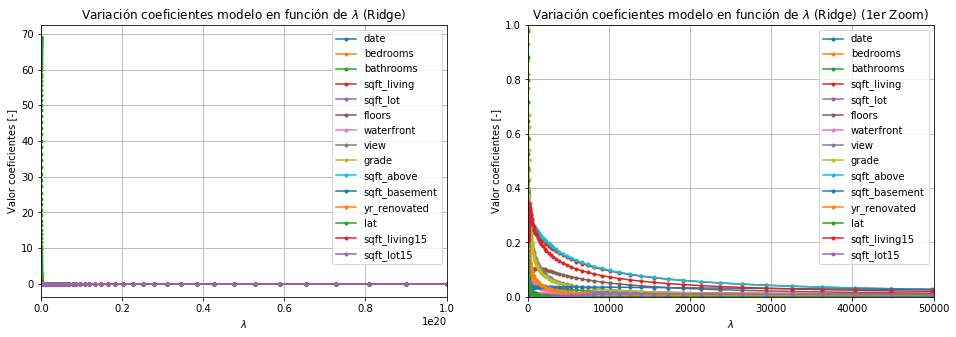

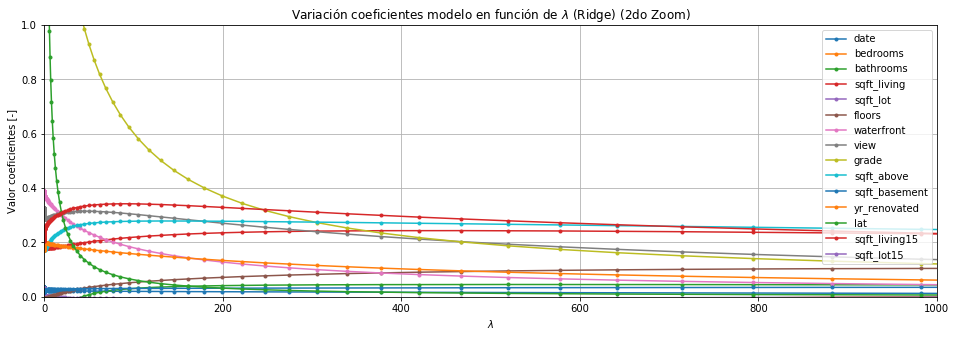

In [77]:
plt.subplot(1,2,1)
plt.title("Variación coeficientes modelo en función de $\lambda$ (Ridge)")
for y_arr, label in zip(pd.np.squeeze(coefsr).T, x_tr.columns):
    plt.plot(spacer, y_arr,'.-', label=label)
plt.legend(loc="upper right")
plt.grid()
plt.ylabel("Valor coeficientes [-]")
plt.xlabel("$\lambda$")
plt.xlim([spacer[0]-5,spacer[-1]])
plt.subplot(1,2,2)
plt.title("Variación coeficientes modelo en función de $\lambda$ (Ridge) (1er Zoom)")
for y_arr, label in zip(pd.np.squeeze(coefsr).T, x_tr.columns):
    plt.plot(spacer, y_arr,'.-', label=label)
plt.legend(loc="upper right")
plt.ylabel("Valor coeficientes [-]")
plt.xlabel("$\lambda$")
plt.grid()
plt.xlim([0,50000])
plt.ylim([0,1])
plt.show()    
plt.title("Variación coeficientes modelo en función de $\lambda$ (Ridge) (2do Zoom)")
for y_arr, label in zip(pd.np.squeeze(coefsr).T, x_tr.columns):
    plt.plot(spacer, y_arr,'.-', label=label)
plt.legend(loc="upper right")
plt.ylabel("Valor coeficientes [-]")
plt.xlabel("$\lambda$")
plt.grid()
plt.xlim([0,1e3])
plt.ylim([0,1])
plt.show()    

*Comentario: Se aprecia que se requieren valores de $\lambda$ muy elevados para llevar los coeficientes a cero, esto dado que la norma que utiliza __Ridge__ provoca que para valores de coeficientes menores que 1 la penalización experimente menor efecto al elevar al cuadrado su valor, a diferencia que con __Lasso__ la cual utiliza el valor absoluto. A la vez se aprecia que los coeficientes tienden a cero de manera suave y no abrupta como en __Lasso__, lo cual va de la mano con el error que siguió el modelo en función de la variación de $\lambda$.*<br><br>
El orden que de eliminación que siguió __Ridge__ fue el siguiente:

In [79]:
ordergoalr=[]
for y_arr, label in zip(pd.np.squeeze(coefsr).T, x_tr.columns):
    x=-1
    for i in y_arr:
        x+=1
        if i<1e-12:
            if y_arr[x+1]<1e-12 and y_arr[x+2]<1e-12 and y_arr[x+3]<1e-12:
                ordergoalr.append([x,label])
                break
x=-1
j=0
for i in range(1000):
    x+=1
    for a in range(len(ordergoalr)):
        if ordergoalr[a][0]<i:
            j+=1
            ordergoalr[a][0]=10001
            print(str(j),"° Less important: ",ordergoalr[a][1])

1 ° Less important:  bedrooms
2 ° Less important:  floors
3 ° Less important:  sqft_lot15
4 ° Less important:  bathrooms
5 ° Less important:  sqft_lot
6 ° Less important:  date
7 ° Less important:  lat
8 ° Less important:  waterfront
9 ° Less important:  yr_renovated
10 ° Less important:  grade
11 ° Less important:  view
12 ° Less important:  sqft_living15
13 ° Less important:  sqft_above
14 ° Less important:  sqft_living
15 ° Less important:  sqft_basement


*Comentario: El cual es distinto al de __Lasso__ y __MI__, sin embargo guarda parentesco con éstos*

Resumen: <br>
1 ° Less important:  __Lasso__: date , __MI__: date , __Ridge__: bedrooms <br>
2 ° Less important:  __Lasso__: bedrooms , __MI__: yr_renovated , __Ridge__: floors <br>
3 ° Less important:  __Lasso__: bathrooms , __MI__: waterfront , __Ridge__: sqft_lot15 <br>
4 ° Less important:  __Lasso__: sqft_lot , __MI__: view , __Ridge__: bathrooms <br>
5 ° Less important:  __Lasso__: floors , __MI__: sqft_lot , __Ridge__: sqft_lot <br>
6 ° Less important:  __Lasso__: sqft_basement , __MI__: floors , __Ridge__: date <br>
7 ° Less important:  __Lasso__: sqft_lot15 , __MI__: bedrooms , __Ridge__: lat <br>
8 ° Less important:  __Lasso__: lat , __MI__: sqft_basement , __Ridge__: waterfront <br>
9 ° Less important:  __Lasso__: waterfront , __MI__: sqft_lot15 , __Ridge__: yr_renovated <br>
10 ° Less important:  __Lasso__: yr_renovated , __MI__: bathrooms , __Ridge__: grade <br>
11 ° Less important:  __Lasso__: grade , __MI__: sqft_above , __Ridge__: view <br>
12 ° Less important:  __Lasso__: view , __MI__: sqft_living15 , __Ridge__: sqft_living15 <br>
13 ° Less important:  __Lasso__: sqft_living15 , __MI__: lat , __Ridge__: sqft_above <br>
14 ° Less important:  __Lasso__: sqft_above , __MI__: grade , __Ridge__: sqft_living <br>
15 ° Less important:  __Lasso__: sqft_living , __MI__: sqft_living , __Ridge__: sqft_basement <br>

#### 2.f K-_fold_ sobre $\lambda$
Realice 5-_fold_ o 10-_fold_ sobre el parámetro de regularización $\lambda$, ya sea para _Lasso_ o _Ridge_. Explore a lo menos 20 valores distintos de $\lambda$ en un intervalo relevante luego de lo aprendido en las preguntas anteriores. Utilice MSE como el error a minimizar. 

Compare el error de entrenamiento y de validación para este modelo respecto al modelo lineal sin regularización entrenado inicialmente. ¿En su opinión se alcanza a apreciar el fenomeno de _overfitting_ para este conjunto de datos y el modelo logístico? 

In [87]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X, y, test_size=0.2)
folds = KFold(10)
xy=np.concatenate((X_cv_train,np.asarray(y_cv_train).reshape(-1,1)),axis=-1)
lambda_values=np.linspace(1e-40,1e-1,2000)
trprom=[]
valprom=[]
testprom=[]
for value in lambda_values:
    tr=[]
    val=[]
    test=[]
    i=0
    for train_index, val_index in folds.split(xy):
        i+=1
        current_model = Ridge(alpha=value)
        current_model.fit(xy[train_index,:-1], xy[train_index,-1])
        tr.append(mean_squared_error(xy[train_index,-1], current_model.predict(xy[train_index,:-1])))
        val.append(mean_squared_error(xy[val_index,-1], current_model.predict(xy[val_index,:-1])))
        test.append(mean_squared_error(np.asarray(y_tst), current_model.predict(x_tst)))
        if i==10:
            trprom.append(sum(tr)/10)
            valprom.append(sum(val)/10)
            testprom.append(sum(test)/10)
            tr=[]
            val=[]
            test=[]

Se encuentra el mejor modelo según el error de validación:

In [88]:
print("Best lambda: ",lambda_values[np.argmin(np.asarray(valprom))])
print("Best validation error: ",valprom[np.argmin(np.asarray(valprom))])
print("Best train error: ",trprom[np.argmin(np.asarray(trprom))])

Best lambda:  1e-40
Best validation error:  0.07225294082975844
Best train error:  0.07211247150279174


*Comentario: Se logró el mejor modelo, como era de esperar, con el $\lambda$ de menor valor que se probó, esto de acuerdo al item 2.d donde se vio cómo aumentaba el error de validación a medida que aumentaba el valor de $\lambda$.*

#### 2.g _Grid search_ para SVM

Para terminar, comparemos el desempeño de los métodos lineales con un método no lineal, las SVM. Para esto buscaremos ajustar los hiperparámetros más relevantes del modelo, en este caso el parámetro `C` y `epsilon`: la penalización y el margen de holgura. Para esto se realiza una busqueda en un mallado de estos parámetros, evaluando MSE a fin de compara con el método lineal utilizado en el punto anterior.

Tal como se mencionó en el item 1.e: <br><br>
*Comentario: El parámetro __C__ es el parámetro de penalización del término de errores en la función de pérdida del modelo, este controla el trade-off entre el tamaño del margen y los errores de clasificación. Es decir... Para valores grandes de C la optimización optará por escoger hyperplanos con menor tamaño de margen de la mano de que se puedan clasificar la mayor cantidad de puntos de entrenamiento correctamente, en caso contrario pequeños valores de C ocasionarán que la optimización busque margenes de mayor tamaño aunque se clasifiquen incorrectamente mayor cantidad de puntos. Es por esto que al disminuir el valor C la frontera se torna más pequeña, dando lugar a un margen de mayor tamaño. A la vez el parámetro C controlará la suavidad de la frontera de decisión, esto en pos de obtener bajos errores de clasificación en el conjunto de entrenamiento.<br><br>*


Mientras el parámetro __epsilon__: <br><br>
*Comentario: El parámetro __epsilon__ en el modelo epsilon-SVR que se está utilizando especifica el tubo-epsilon en el cual no se asociará penalización en la función de pérdida de entrenamiento con puntos predichos con una distancia epsilon del valor actual. Es decir el valor que asuma este parámetro tiene inferencia en cuáles vectores de soporte utilizará el modelo, y a cuál distancia se ubicarán de la frontera de decisión.*

In [110]:
from sklearn.svm import SVR
C_params = []
epsilon_params = []
train_errors = []
val_errors = []
models = []
best_C = 0
best_epsilon = 0
best_val_err = float("inf")
best_train_err = float("inf")
best_model = None
Cs, epsilons = pd.np.meshgrid([i for i in range(15,40)],[i/60 for i in range(1,41)])
for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon, gamma='scale',verbose=False)
    sv.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, sv.predict(x_tr))
    val_err = mean_squared_error(y_val, sv.predict(x_val))
    C_params.append(C)
    epsilon_params.append(epsilon)
    train_errors.append(train_err)
    val_errors.append(val_err)
    models.append(sv)
    if (val_err < best_val_err):
        best_C = C
        best_epsilon = epsilon
        best_val_err = val_err
        best_train_err = train_err
        best_model = sv
test_err = mean_squared_error(y_tst, best_model.predict(x_tst))

Se encuentra el mejor modelo en base al error de validación

In [111]:
print("Best model C value: ",best_C[0])
print("Best model epsilon value: ",best_epsilon[0])
print("Best model validation error: ",best_val_err)
print("Best model train error: ",best_train_err)
print("Best model test error: ",test_err)

Best model C value:  19
Best model epsilon value:  0.13333333333333333
Best model validation error:  0.10047201543555592
Best model train error:  0.0990905327404596
Best model test error:  0.10227924076512653


El cual posee peor desempeño que el que se obtiene aplicando un modelo lineal

In [117]:
reg = LinearRegression()
reg.fit(x_tr, y_tr)
reg_train_err = mean_squared_error(y_tr, reg.predict(x_tr))
reg_val_err = mean_squared_error(y_val, reg.predict(x_val))
reg_test_err = mean_squared_error(y_tst, reg.predict(x_tst))
print("Training error:", reg_train_err)
print("Validation error:", reg_val_err)
print("Test error:", reg_test_err)

Training error: 0.0717904324019669
Validation error: 0.07293968773878394
Test error: 0.07242313257187001


Se muestra a continuación un mapa de calor que indica el error de validación del modelo no lineal en función de los parámetros C y  epsilon.

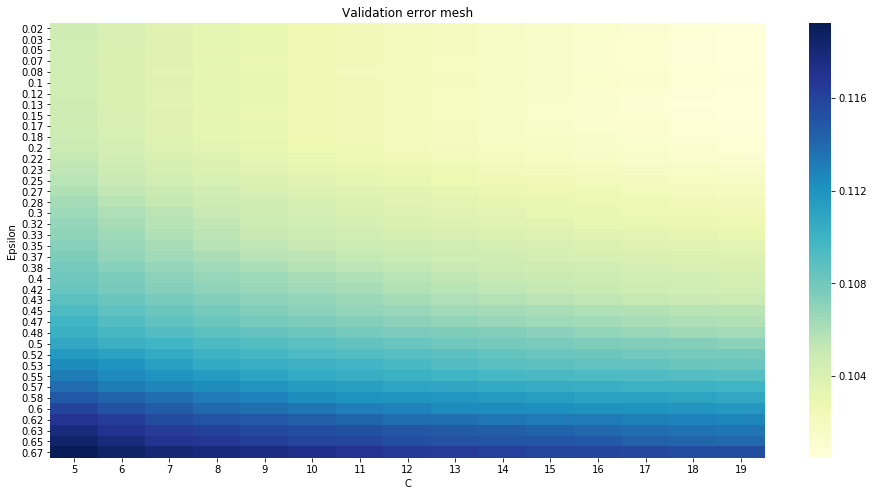

In [182]:
plt.rcParams["figure.figsize"]=[16,8]
plt.title("Validation error mesh")
sns.heatmap(np.split(np.asarray(val_errors),np.asarray(val_errors).shape[0]/15),cmap="YlGnBu",xticklabels=Cs[0],yticklabels=[np.round(epsilons[i][0],2) for i in range(epsilons.shape[0])])
plt.xlabel("C")
# plt.grid()
plt.ylabel("Epsilon")
plt.show()

*Comentario: Se aprecia que el mínimo se ubica en una esquina por lo que se vuelve a entrenar el modelo no lineal expandiéndolo por esta esquina superior derecha*

In [194]:
C_params = []
epsilon_params = []
train_errors = []
val_errors = []
models = []
best_C = 0
best_epsilon = 0
best_val_err = float("inf")
best_train_err = float("inf")
best_model = None
Cs, epsilons = pd.np.meshgrid([i for i in range(80,240,4)],[i/100 for i in range(1,60,2)])
for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon, gamma='scale',verbose=False)
    sv.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, sv.predict(x_tr))
    val_err = mean_squared_error(y_val, sv.predict(x_val))
    C_params.append(C)
    epsilon_params.append(epsilon)
    train_errors.append(train_err)
    val_errors.append(val_err)
    models.append(sv)
    if (val_err < best_val_err):
        best_C = C
        best_epsilon = epsilon
        best_val_err = val_err
        best_train_err = train_err
        best_model = sv
test_err = mean_squared_error(y_tst, best_model.predict(x_tst))

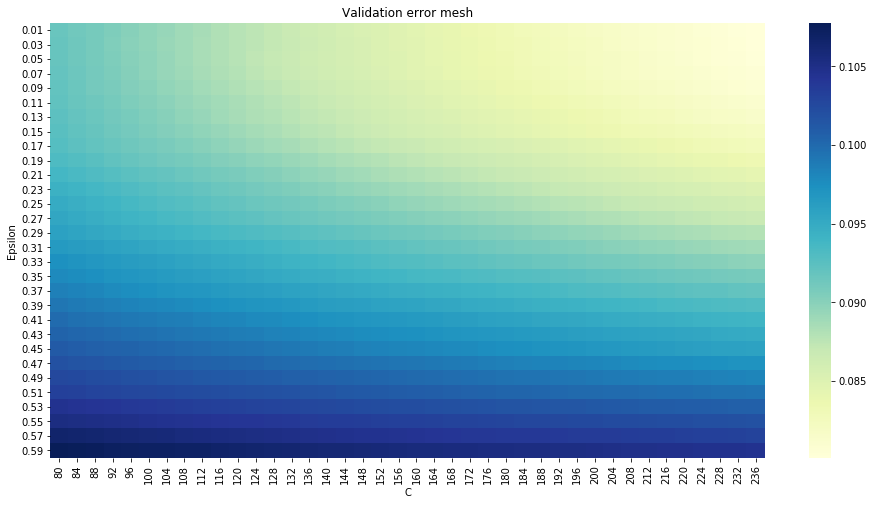

In [195]:
plt.rcParams["figure.figsize"]=[16,8]
plt.title("Validation error mesh")
sns.heatmap(np.split(np.asarray(val_errors),np.asarray(val_errors).shape[0]/np.asarray(Cs[0]).shape[0]),cmap="YlGnBu",xticklabels=Cs[0],yticklabels=[np.round(epsilons[i][0],5) for i in range(epsilons.shape[0])])
plt.xlabel("C")
# plt.grid()
plt.ylabel("Epsilon")
plt.show()

In [196]:
print("Best model C value: ",best_C[0])
print("Best model epsilon value: ",best_epsilon[0])
print("Best model validation error: ",best_val_err)
print("Best model train error: ",best_train_err)
print("Best model test error: ",test_err)

Best model C value:  236
Best model epsilon value:  0.01
Best model validation error:  0.0801306061972105
Best model train error:  0.07811557644770903
Best model test error:  0.08143306330135468


Nuevamente se encuentra el mínimo en una esquina, por lo que se intenta otro enmallado que se expanda a partir de esta esquina y con rangos apreciables para C y epsilon

In [217]:
C_params = []
epsilon_params = []
train_errors = []
val_errors = []
models = []
best_C = 0
best_epsilon = 0
best_val_err = float("inf")
best_train_err = float("inf")
best_model = None
Cs, epsilons = pd.np.meshgrid([i for i in range(1000,20001,1000)],[i/20000 for i in range(1,1001,100)])
for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon, gamma='scale',verbose=False)
    sv.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, sv.predict(x_tr))
    val_err = mean_squared_error(y_val, sv.predict(x_val))
    C_params.append(C)
    epsilon_params.append(epsilon)
    train_errors.append(train_err)
    val_errors.append(val_err)
    models.append(sv)
    if (val_err < best_val_err):
        best_C = C
        best_epsilon = epsilon
        best_val_err = val_err
        best_train_err = train_err
        best_model = sv
test_err = mean_squared_error(y_tst, best_model.predict(x_tst))

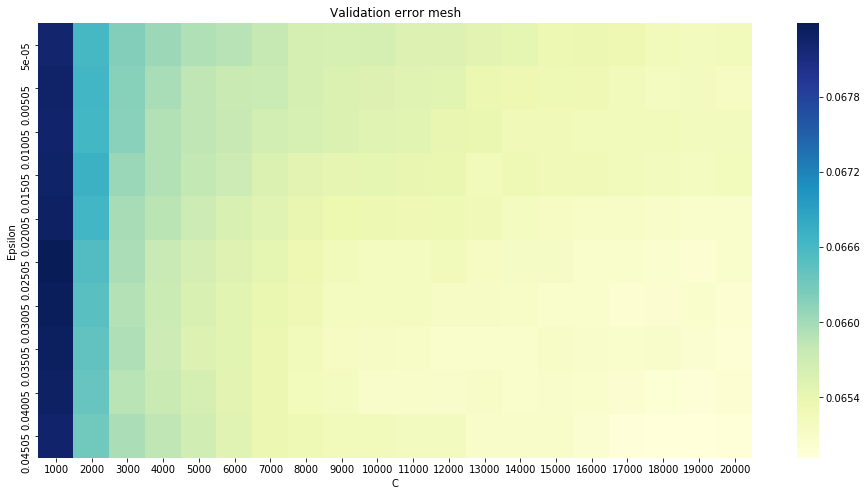

In [218]:
plt.rcParams["figure.figsize"]=[16,8]
plt.title("Validation error mesh")
sns.heatmap(np.split(np.asarray(val_errors),np.asarray(val_errors).shape[0]/np.asarray(Cs[0]).shape[0]),cmap="YlGnBu",xticklabels=Cs[0],yticklabels=[np.round(epsilons[i][0],5) for i in range(epsilons.shape[0])])
plt.xlabel("C")
# plt.grid()
plt.ylabel("Epsilon")
plt.show()

In [219]:
print("Best model C value: ",best_C[0])
print("Best model epsilon value: ",best_epsilon[0])
print("Best model validation error: ",best_val_err)
print("Best model train error: ",best_train_err)
print("Best model test error: ",test_err)

Best model C value:  18000
Best model epsilon value:  0.04505
Best model validation error:  0.06491669030924675
Best model train error:  0.06024939258513792
Best model test error:  0.06600175741774103


*Comentario: Se encontró un valor de C óptimo dentro de su rango de búsqueda, sin embargo el valor de epsilon se encuentra en un extremo, por lo cual se procede a hacer un enmallado más fino cerca de estos valores. Cabe resaltar que a estas alturas ya se ha encontrado un error de validación del modelo no lineal inferior al modelo lineal, siendo la predicción de mayor calidad*

In [232]:
C_params = []
epsilon_params = []
train_errors = []
val_errors = []
models = []
best_C = 0
best_epsilon = 0
best_val_err = float("inf")
best_train_err = float("inf")
best_model = None
Cs, epsilons = pd.np.meshgrid([i for i in range(17000,19001,100)],[i/20000 for i in range(1,701,100)])
for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon, gamma='scale',verbose=False)
    sv.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, sv.predict(x_tr))
    val_err = mean_squared_error(y_val, sv.predict(x_val))
    C_params.append(C)
    epsilon_params.append(epsilon)
    train_errors.append(train_err)
    val_errors.append(val_err)
    models.append(sv)
    if (val_err < best_val_err):
        best_C = C
        best_epsilon = epsilon
        best_val_err = val_err
        best_train_err = train_err
        best_model = sv
test_err = mean_squared_error(y_tst, best_model.predict(x_tst))

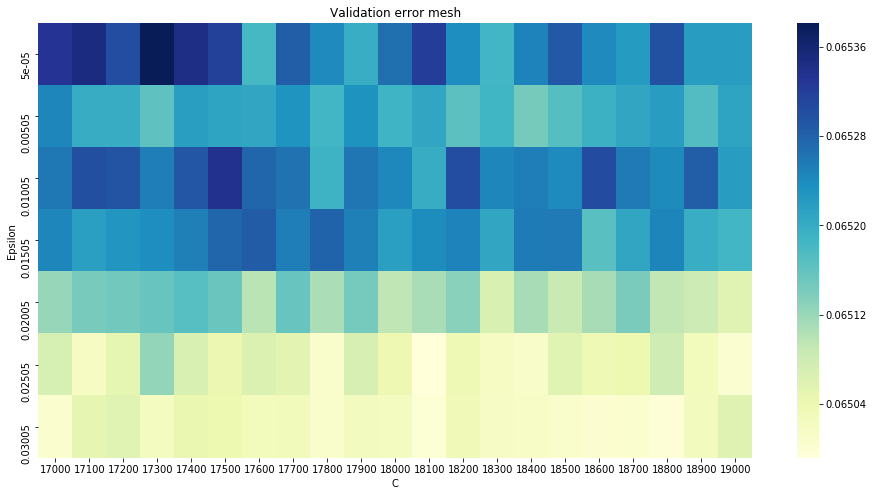

In [233]:
plt.rcParams["figure.figsize"]=[16,8]
plt.title("Validation error mesh")
sns.heatmap(np.split(np.asarray(val_errors),np.asarray(val_errors).shape[0]/np.asarray(Cs[0]).shape[0]),cmap="YlGnBu",xticklabels=Cs[0],yticklabels=[np.round(epsilons[i][0],5) for i in range(epsilons.shape[0])])
plt.xlabel("C")
# plt.grid()
plt.ylabel("Epsilon")
plt.show()

In [234]:
print("Best model C value: ",best_C[0])
print("Best model epsilon value: ",best_epsilon[0])
print("Best model validation error: ",best_val_err)
print("Best model train error: ",best_train_err)
print("Best model test error: ",test_err)

Best model C value:  18100
Best model epsilon value:  0.02505
Best model validation error:  0.06499190834115223
Best model train error:  0.06023829777822338
Best model test error:  0.06611629202012476


*Comentario: Se encuentra el mínimo error de validación dentro del rango de búsqueda el cual a la vez es menor que el modelo lineal. Vale la pena recalcar que en esta búsqueda se ha hecho un supuesto fuerte, puesto no se ha hecho cross-validation para cada uno de los modelos evaluados sino que se ha mantenido estáticos los conjuntos de entrenamiento y validación, bien se ha procedido de este modo por los largos tiempo de entrenamiento de cada modelo, el realizar cross-validation multiplicaría por 10 el tiempo de espera, bien la implementación sería una mezcla del ítem previo con el algoritmo mostrado en este ítem.*

Como último paso se procede a realizar una búsqueda en un rango pequeño al rededor del mínimo encontrado.

In [242]:
C_params = []
epsilon_params = []
train_errors = []
val_errors = []
models = []
best_C = 0
best_epsilon = 0
best_val_err = float("inf")
best_train_err = float("inf")
best_model = None
Cs, epsilons = pd.np.meshgrid([i for i in range(18000,18201,25)],[i/20000 for i in range(1100,4801,100)])
for C, epsilon in zip(Cs.reshape((-1,1)), epsilons.reshape((-1,1))):
    sv = SVR(C=C, epsilon=epsilon, gamma='scale',verbose=False)
    sv.fit(x_tr, y_tr)
    train_err = mean_squared_error(y_tr, sv.predict(x_tr))
    val_err = mean_squared_error(y_val, sv.predict(x_val))
    C_params.append(C)
    epsilon_params.append(epsilon)
    train_errors.append(train_err)
    val_errors.append(val_err)
    models.append(sv)
    if (val_err < best_val_err):
        best_C = C
        best_epsilon = epsilon
        best_val_err = val_err
        best_train_err = train_err
        best_model = sv
test_err = mean_squared_error(y_tst, best_model.predict(x_tst))

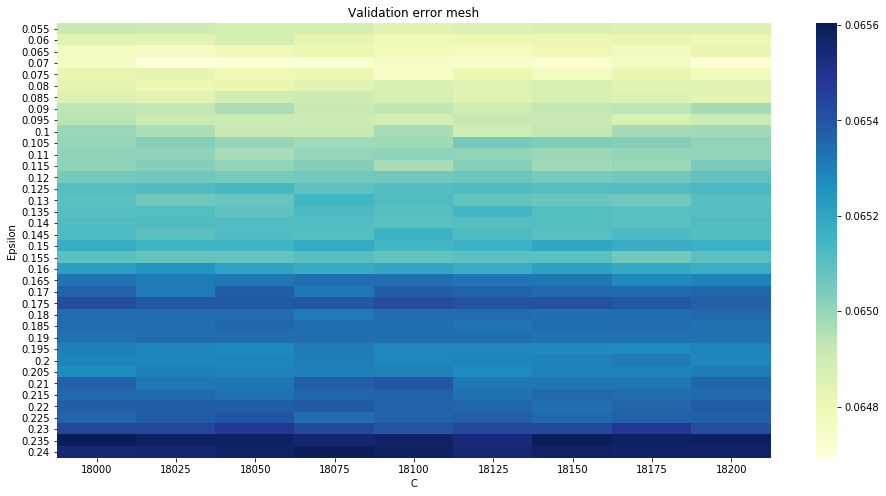

In [243]:
plt.rcParams["figure.figsize"]=[16,8]
plt.title("Validation error mesh")
sns.heatmap(np.split(np.asarray(val_errors),np.asarray(val_errors).shape[0]/np.asarray(Cs[0]).shape[0]),cmap="YlGnBu",xticklabels=Cs[0],yticklabels=[np.round(epsilons[i][0],5) for i in range(epsilons.shape[0])])
plt.xlabel("C")
# plt.grid()
plt.ylabel("Epsilon")
plt.show()

In [244]:
print("Best model C value: ",best_C[0])
print("Best model epsilon value: ",best_epsilon[0])
print("Best model validation error: ",best_val_err)
print("Best model train error: ",best_train_err)
print("Best model test error: ",test_err)

Best model C value:  18025
Best model epsilon value:  0.07
Best model validation error:  0.06469260304775655
Best model train error:  0.06006704484302877
Best model test error:  0.06601224963396402
